In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

#import pingouin as pg
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from matplotlib import ticker

%matplotlib inline 

from platform import python_version
print(python_version())

3.12.7


# MarketScan PRCCSR Counts

In [3]:
df_census = pd.read_csv('msa_census_2019.csv')
df_census.columns

Index(['Unnamed: 0', 'MSA', 'EGEOLOC', 'Total Pop', 'Square Miles',
       'frac_female', 'frac_white', 'frac_black', 'frac_hispanic',
       'frac_asian', 'frac_other', 'frac_under_18', 'frac_18_to_39',
       'frac_40_to_64', 'frac_over_65', 'frac_lt_20k', 'frac_20k_to_40k',
       'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k',
       'frac_gt_200k', 'frac_unemployed', 'frac_no_health_insurance',
       'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college',
       'frac_graduate', 'frac_houses_owner_occupied', 'median_house_price',
       'pop_density', 'State Name', 'Name'],
      dtype='object')

In [4]:
#xls = pd.ExcelFile('MS_2019_procedure_counts_UPDATED.xlsx')
xls = pd.ExcelFile('pccsr_counts_excl_output.xlsx')
xls.sheet_names

['procedure_counts_18_64', 'memdays_18_64']

In [5]:
#df_counts = pd.read_excel('MarketScan_PCCRS_Inpatient_Counts_2019.xlsx')
#df_memdays = pd.read_excel(xls, 'mem_days')

df_counts = pd.read_excel(xls, 'procedure_counts_18_64')
df_memdays = pd.read_excel(xls, 'memdays_18_64')

In [6]:
for procedure in df_counts.PRCCSR.drop_duplicates():
    df_temp = df_counts[df_counts.PRCCSR == procedure].reset_index()
    proc_name = df_temp.PRCCSR_DESCRIPTION[0]
    df_memdays = pd.merge(df_memdays, df_temp[['MSA', 'EGEOLOC', 'num']], how='left', on=['MSA', 'EGEOLOC']).rename(columns={'num': proc_name})
    df_memdays[proc_name] = df_memdays[proc_name].fillna(0)/df_memdays.mem_days*36500

In [8]:
#df_memdays.tail()

In [9]:
(df_memdays['Overall Inpatient Visits']*df_memdays['mem_days']).sum()/100 #/ df_memdays['mem_days'].sum()

254326160.0

In [10]:
(df_memdays['Overall Inpatient Visits']*df_memdays['mem_days']).sum() / df_memdays['mem_days'].sum()

4.909297021781273

In [11]:
df = pd.merge(df_census, df_memdays, on=['MSA', 'EGEOLOC'])
procedures = df.columns[34:]

In [12]:
df.columns[0:30]

Index(['Unnamed: 0', 'MSA', 'EGEOLOC', 'Total Pop', 'Square Miles',
       'frac_female', 'frac_white', 'frac_black', 'frac_hispanic',
       'frac_asian', 'frac_other', 'frac_under_18', 'frac_18_to_39',
       'frac_40_to_64', 'frac_over_65', 'frac_lt_20k', 'frac_20k_to_40k',
       'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k',
       'frac_gt_200k', 'frac_unemployed', 'frac_no_health_insurance',
       'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college',
       'frac_graduate', 'frac_houses_owner_occupied', 'median_house_price'],
      dtype='object')

In [13]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [15]:
df.groupby('EGEOLOC')[['Overall Inpatient Visits', 'mem_days']].sum()

,Overall Inpatient Visits,mem_days
EGEOLOC,,
4,28.580935,46351439
5,19.759656,13619428
6,36.496214,87361856
7,13.814886,11412722
8,5.347430,8320539
9,9.510498,3593619
11,51.761637,155052547
12,76.191821,295693592
13,119.614326,156772609


In [16]:
#this code does partial correlations controling for state

df_procs = pd.DataFrame([])
df_procs['procedure'] = procedures
temp = []
for pp in procedures:
    temp = temp + [(df[pp] * df.mem_days).sum() / df.mem_days.sum()]
df_procs['rate'] = temp

features = ['frac_white', 'frac_lt_40k', 'frac_college_plus', 'frac_40_to_64', 'median_house_price']

for feature in features:
    df_procs['corr_' + feature] = -999.

for proc in procedures:
    df_temp = df[[proc, 'State Name', 'mem_days', 'frac_white', 'frac_40_to_64', 'frac_lt_20k', 'frac_20k_to_40k', 'frac_college','frac_graduate', 'median_house_price']].copy()
    df_temp['frac_lt_40k'] = df_temp.frac_lt_20k + df_temp.frac_20k_to_40k
    df_temp['frac_college_plus'] = df_temp.frac_college + df_temp.frac_graduate
    df_temp['phat'] = df_temp[proc].clip(lower = np.percentile(df_temp[df_temp[proc]>0][proc], 5),
                                     upper = np.percentile(df_temp[df_temp[proc]>0][proc], 95))
    df_temp['weight'] = df_temp['mem_days']/df_temp['phat']
    
    for feature in features:
        X = sm.add_constant(pd.get_dummies(df_temp['State Name']).iloc[:,:-1]).astype(int)
        y = df_temp[proc]
        weight = df_temp['weight']

        est = sm.WLS(y, X, weights=weight).fit() 
        resid_Optum = est.resid

        y = df_temp[feature]

        est = sm.WLS(y, X, weights = weight).fit() 
        resid_feature = est.resid

        df_procs.loc[df_procs.procedure == proc, 'corr_' + feature] = corr(resid_feature, resid_Optum, weight)

In [18]:
df_procs = pd.DataFrame([])
df_procs['procedure'] = procedures
temp = []
for pp in procedures:
    temp = temp + [(df[pp] * df.mem_days).sum() / df.mem_days.sum()]
df_procs['rate'] = temp

features = ['frac_white', 'frac_lt_40k', 'frac_college_plus']

for feature in features:
    df_procs['corr_' + feature] = -999.

for proc in procedures:
    df_temp = df[[proc, 'State Name', 'mem_days', 'frac_white', 'frac_40_to_64', 'frac_lt_20k', 'frac_20k_to_40k', 'frac_college','frac_graduate']].copy()
    df_temp['frac_lt_40k'] = df_temp.frac_lt_20k + df_temp.frac_20k_to_40k
    df_temp['frac_college_plus'] = df_temp.frac_college + df_temp.frac_graduate
    df_temp['phat'] = df_temp[proc].clip(lower = np.percentile(df_temp[df_temp[proc]>0][proc], 5),
                                     upper = np.percentile(df_temp[df_temp[proc]>0][proc], 95))
    df_temp['weight'] =  df_temp['mem_days']/df_temp['phat']
    
    for feature in features:
        df_procs.loc[df_procs.procedure == proc, 'corr_' + feature] = corr(df_temp[proc], df_temp[feature], df_temp['weight'])

In [19]:
df_procs.sort_values(by='rate', ascending=False)[0:20]

,procedure,rate,corr_frac_white,corr_frac_lt_40k,corr_frac_college_plus
274,Overall Inpatient Visits,5.385581,0.190207,0.474372,-0.494834
261,Spontaneous vaginal delivery,0.863091,-0.013948,-0.228154,0.243331
53,Cesarean section,0.469178,-0.399249,-0.057319,0.114580
21,Assisted vaginal delivery,0.395784,0.144968,-0.114502,0.116612
206,Perineal muscle laceration repair (2nd degree ...,0.306756,-0.070693,-0.478637,0.529411
144,Intravenous induction of labor,0.247657,0.151342,0.017288,0.005819
104,Fetal heart rate monitoring,0.206621,-0.090448,-0.068342,0.089189
288,Venous and arterial catheter placement,0.194770,-0.095356,0.356935,-0.340617
207,Perineal skin repair (1st degree obstetrical a...,0.186998,-0.172041,-0.322960,0.306497
170,Measurement during cardiac catheterization,0.138442,0.099777,0.501634,-0.473880


# Read in SID data

In [20]:
df_pccrs = pd.read_excel('PRCCSR_classification.xlsx')

In [21]:
df_pccrs.tail()

,ICD-10-PCS,ICD-10-PCS DESCRIPTION,PRCCSR,PRCCSR DESCRIPTION,CLINICAL DOMAIN
81592,XXE97U7,"Measurement of Infection, Nasopharyngeal Fluid...",MAM015,"Measurement and monitoring, NEC",Measurement and Monitoring
81593,XXEBXQ6,"Measurement of Infection, Lower Respiratory Fl...",MAM014,Pulmonary function tests,Measurement and Monitoring
81594,XY0VX83,Extracorporeal Introduction of Endothelial Dam...,ADM021,"Administration of therapeutic substances, NEC",Administration of Therapeutic Substances
81595,XY0YX28,Extracorporeal Introduction of Taurolidine Ant...,ADM021,"Administration of therapeutic substances, NEC",Administration of Therapeutic Substances
81596,XY0YX37,Extracorporeal Introduction of Nafamostat Anti...,ADM021,"Administration of therapeutic substances, NEC",Administration of Therapeutic Substances


In [237]:
states = ['IA', 'NJ', 'MD', 'CA', 'MI']
state_names = ['Iowa', 'New Jersey', 'Maryland', 'California', 'Michigan']

cols = ['ZIP', 'PRCCSR', 'row_num']
df_counts = pd.DataFrame([], columns = cols)

for state in states:
    print(state)
    df_temp = pd.read_csv('SID Data -- 2019/SID_' + state + '_2019_Full.csv', low_memory=False)
    
    if state == 'CA':
        df_temp = df_temp[df_temp.HospitalUnit == 1].reset_index().copy()
    if state == 'MD':
        df_temp = df_temp[df_temp.HospitalUnit != 6].reset_index().copy()
    
    proc_cols = [i for i, s in enumerate(df_temp.columns) if 'I10_PR' in s]
    loc_cols = [i for i, s in enumerate(df_temp.columns) if 'ZIP' in s]
    df_temp = df_temp[(pd.to_numeric(df_temp['AGE'], errors='coerce') <= 64)
                     &(pd.to_numeric(df_temp['AGE'], errors='coerce') >= 18)].iloc[:, proc_cols + loc_cols].copy()
    df_temp['row_num'] = df_temp.index
    
    df_procs = pd.DataFrame([], columns = cols)
    for proc_col in [s for i, s in enumerate(df_temp.columns) if 'I10_PR' in s and 'PROCTYPE' not in s]:
        df_tt = pd.merge(df_temp[[proc_col, 'ZIP', 'row_num']], df_pccrs, left_on = proc_col, right_on = 'ICD-10-PCS')
        df_procs = pd.concat([df_procs, df_tt[cols]])
    df_counts = pd.concat([df_counts, df_procs.groupby(['ZIP', 'PRCCSR']).row_num.nunique().reset_index().rename(columns={'row_num':'count'})])

    df_tot_hosps = pd.DataFrame(df_temp.groupby('ZIP').size()).rename(columns={0:'count'}).reset_index()
    df_tot_hosps['PRCCSR'] = 'XXX'
    df_tot_hosps['row_num'] = np.nan
    df_counts = pd.concat([df_counts, df_tot_hosps])
    
df_counts = df_counts.groupby(['ZIP', 'PRCCSR'])['count'].sum().reset_index()

IA


/var/folders/kd/5z7n_h8j5cq1f4ybg56gdyph0000gq/T/ipykernel_21128/3040770640.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_procs = pd.concat([df_procs, df_tt[cols]])
/var/folders/kd/5z7n_h8j5cq1f4ybg56gdyph0000gq/T/ipykernel_21128/3040770640.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_counts = pd.concat([df_counts, df_procs.groupby(['ZIP', 'PRCCSR']).row_num.nunique().reset_index().rename(columns={'row_num':'count'})])


NJ
MD
CA
MI


In [238]:
df_tt = pd.merge(df_counts, df_pccrs[['PRCCSR', 'PRCCSR DESCRIPTION']].drop_duplicates(), on='PRCCSR', how='left')
df_tt.loc[df_tt.PRCCSR == 'XXX', 'PRCCSR DESCRIPTION'] = 'Overall Inpatient Visits'
df_tt['ZIP'] = pd.to_numeric(df_tt['ZIP'], errors='coerce')
df_tt = df_tt[~df_tt.ZIP.isna()].copy()
df_tt['ZIP'] = df_tt['ZIP'].astype(int)
df_tt.to_csv('SID_zip_counts_no_psych.csv')

In [239]:
df_tt_old = pd.read_csv('SID_zip_counts.csv')

In [240]:
df_change = df_tt_old.groupby('PRCCSR DESCRIPTION')['count'].sum() - df_tt.groupby('PRCCSR DESCRIPTION')['count'].sum()
(100* df_change / df_tt_old.groupby('PRCCSR DESCRIPTION')['count'].sum()).sort_values()[-50:]

PRCCSR DESCRIPTION
Incision and drainage of skin                                   0.440827
Dental procedures                                               0.450225
Electroencephalogram (EEG)                                      0.458149
Packing and dressing procedures                                 0.460487
Bladder catheterization and drainage                            0.461741
Mechanical ventilation                                          0.462800
Laryngoscopy (diagnostic)                                       0.476863
ENT diagnostic procedures (non-endoscopic)                      0.487805
Administration of diagnostic substances, NEC                    0.502176
Subcutaneous tissue and fascia procedures, NEC                  0.540541
Non-invasive ventilation                                        0.560498
Hemodialysis                                                    0.616427
Administration of antibiotics                                   0.648557
Immobilization by splint or othe

In [241]:
df_crosswalk = pd.read_excel('ZIP_COUNTY_122019.xlsx')

df_counts['ZIP'] = pd.to_numeric(df_counts['ZIP'], errors='coerce')
df_counts = df_counts[~df_counts.ZIP.isna()].copy()
df_counts['ZIP'] = df_counts['ZIP'].astype(int)

df_tt = pd.merge(df_counts, df_crosswalk, on='ZIP')
df_tt['count_adjusted'] = df_tt['count'] * df_tt['RES_RATIO']

In [242]:
df_sid_county = pd.DataFrame(df_tt.groupby(['COUNTY', 'PRCCSR'])['count_adjusted'].sum()).rename(columns={'count_adjusted': 'count'}).reset_index()
df_sid_county['FIPS State Code'] = np.floor(df_sid_county['COUNTY']/1000).astype(int)
df_sid_county['FIPS County Code'] = np.mod(df_sid_county['COUNTY'],1000).astype(int)

In [243]:
df_msa_x = pd.read_csv('crosswalk_after_2014.csv')

df_stage = pd.merge(df_msa_x, df_sid_county[['FIPS State Code', 'FIPS County Code', 'PRCCSR', 'count']],
        how='left', on = ['FIPS State Code', 'FIPS County Code'])
df_sid_counts = df_stage.groupby(['MSA', 'EGEOLOC', 'State Name', 'PRCCSR'])['count'].sum().reset_index()

In [244]:
df_sid_counts = df_sid_counts[df_sid_counts['State Name'].isin(state_names)].copy()
df_sid_counts = pd.merge(df_sid_counts, df_pccrs[['PRCCSR', 'PRCCSR DESCRIPTION']].drop_duplicates(), on='PRCCSR', how='left')
df_sid_counts.loc[df_sid_counts['PRCCSR'] == 'XXX', 'PRCCSR DESCRIPTION'] = 'Overall Inpatient Visits'
df_sid_counts.to_csv('sid_2019_msa_counts.csv')

# compare SID to MarketScan

In [22]:
df_sid_counts = pd.read_csv('sid_2019_msa_counts.csv')

In [23]:
df_sid_counts[df_sid_counts['PRCCSR DESCRIPTION'] == 'Cesarean section'].groupby('State Name')['count'].sum()

State Name
California    129081.0
Iowa            9944.0
Maryland       19996.0
Michigan       32842.0
New Jersey     30066.0
Name: count, dtype: float64

In [24]:
df_temp = df[['MSA', 'EGEOLOC']].copy()
df_temp['Pop 18 to 65'] = df['Total Pop'] * (1 - df['frac_over_65'] - df['frac_under_18'])

df_temp = pd.merge(df_temp, 
                  df_sid_counts[df_sid_counts['PRCCSR DESCRIPTION'].isin(procedures)],
                  on=['MSA', 'EGEOLOC'])
df_sid = df_temp[['MSA', 'EGEOLOC', 'State Name', 'Pop 18 to 65']].drop_duplicates()

for proc in procedures:
    df_sid = pd.merge(df_sid, 
                      df_temp[df_temp['PRCCSR DESCRIPTION'] == proc][['MSA', 'EGEOLOC', 'count']], 
                      on=['MSA', 'EGEOLOC'], 
                      how='left')
    df_sid['count'] = df_sid['count'].fillna(0) / df_sid['Pop 18 to 65'] * 100
    df_sid.rename(columns={'count': proc}, inplace=True)

In [26]:
(df_sid['Overall Inpatient Visits']*df_sid['Pop 18 to 65']).sum()/100 #/ df_memdays['mem_days'].sum()

2945667.0

In [27]:
(df_sid['Overall Inpatient Visits']*df_sid['Pop 18 to 65']).sum() / df_sid['Pop 18 to 65'].sum()

7.003023670233176

In [28]:
#check which procedures have distributions that are highly skewed by state

In [29]:
from scipy.stats import chi2_contingency

vals_temp = list(df_sid_counts.groupby('PRCCSR DESCRIPTION')['count'].sum().sort_values()[-260:].index)

In [30]:
pop_vec = df_sid.groupby('State Name')['Pop 18 to 65'].sum()
df_ans = pd.DataFrame([], columns = ['procedure', 'chi-squared', 'p', 'dof'])
ii = 0
for procedure in vals_temp:
    proc_count_vec = df_sid_counts[df_sid_counts['PRCCSR DESCRIPTION'] == procedure].groupby('State Name')['count'].sum()
    proc_count_vec = (pop_vec*0 + proc_count_vec).fillna(0)
    contingency = [list(pop_vec - proc_count_vec), list(proc_count_vec)]
    c, p, dof, expected = chi2_contingency(contingency)
    df_ans.loc[ii] = [procedure, c, p, dof]
    ii+=1    

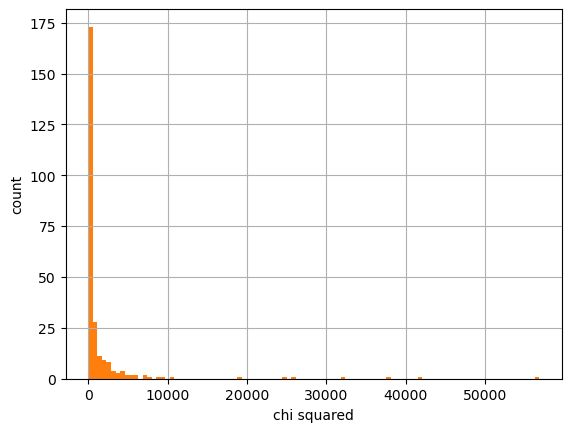

In [32]:
df_ans[df_ans['procedure'] != 'Overall Inpatient Visits']['chi-squared'].hist(bins=100)
plt.xlabel('chi squared')
plt.ylabel('count')
plt.show()

In [44]:
df_ans[df_ans['procedure'] != 'Overall Inpatient Visits'].sort_values(by='chi-squared', ascending = False)[:10]

,procedure,chi-squared,p,dof
162,Psychotherapy for mental health (excluding sub...,56838.394578,0.0,4
119,Pharmacotherapy for mental health (excluding s...,41547.355354,0.0,4
217,Substance use detoxification,37846.459495,0.0,4
115,Isolation procedures,32373.033917,0.0,4
136,Cardiac monitoring,25971.415805,0.0,4
207,Spinal epidural catheter placement,24485.874607,0.0,4
91,"Artery, vein, and great vessel procedures, NEC",18811.422849,0.0,4
239,Regional anesthesia,10674.559190,0.0,4
133,"Physical, occupational, and respiratory therap...",9207.963892,0.0,4
54,Pharmacotherapy for substance use,8912.235796,0.0,4


In [34]:
exclude_list = list(df_ans[(df_ans['chi-squared'] > 7500) & (df_ans['procedure'] != 'Overall Inpatient Visits')].procedure)

In [35]:
#for each procedure, estimate the rate in MS and SID

df_procs = pd.DataFrame([], columns = ['procedure', 'rate_MS', 'err_rate_MS', 'rate_SID', 'err_rate_SID', 'rel_bias', 'rel_bias_low', 'rel_bias_high'])
ii = 0
for proc in procedures:
    df_temp = pd.merge(df_sid[['MSA', 'EGEOLOC', 'Pop 18 to 65', proc]], df[['MSA', 'EGEOLOC', proc, 'Total Pop', 'mem_days']], on=['MSA', 'EGEOLOC'], how='outer').rename(columns = {proc+'_x': 'sid', proc+'_y': 'ms'}).fillna(0)
    df_temp = df_temp[df_temp.EGEOLOC.isin([11, 18, 22, 35, 62])]
    rate_ms = (df_temp.ms * df_temp.mem_days).sum() / df_temp.mem_days.sum()
    rate_sid = (df_temp.sid * df_temp['Pop 18 to 65']).sum() / df_temp['Pop 18 to 65'].sum()
    rel_bias = rate_ms / rate_sid
    err_rate_ms = (rate_ms / df_temp.mem_days.sum() * 36500) ** 0.5
    err_rate_sid = (rate_sid / df_temp['Pop 18 to 65'].sum()) ** 0.5
    err_log_rel_bias = ((err_rate_ms / rate_ms)**2 + (err_rate_sid / rate_sid)**2) ** 0.5
    df_procs.loc[ii] = [proc, rate_ms, err_rate_ms, rate_sid, err_rate_sid, rel_bias, np.exp(np.log(rel_bias) - 1.96 * err_log_rel_bias), np.exp(np.log(rel_bias) + 1.96 * err_log_rel_bias)]
    ii += 1

In [124]:
(df[df.EGEOLOC.isin([11, 18, 22, 35, 62])]['Overall Inpatient Visits']*df[df.EGEOLOC.isin([11, 18, 22, 35, 62])]['mem_days']).sum()/365/100 #[['MSA', 'EGEOLOC', 'Overall Inpatient Visits', 'Total Pop', 'mem_days']]

114756.0

In [128]:
df[df.EGEOLOC.isin([11, 18, 22, 35, 62])].mem_days.sum()/365

2292269.2794520548

In [126]:
df[df.EGEOLOC.isin([11, 18, 22, 35, 62])].mem_days.sum()/2793302

299.53019294011176

In [48]:
df_procs = df_procs[~df_procs.procedure.isin(exclude_list)]

In [49]:
#top 10 most over-estimated
df_temp = df_procs[df_procs['procedure'] != 'Overall Inpatient Visits'].sort_values(by = 'rate_SID', ascending=False)[:250]
df_temp.sort_values(by = 'rel_bias', ascending=False)[0:10]

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high
254,Speech therapy treatment,0.005584,0.000494,0.003530,0.000009,1.581670,1.329982,1.880988
229,Prostatectomy,0.018453,0.000897,0.012591,0.000017,1.465632,1.332357,1.612237
31,Breast reconstruction,0.019718,0.000927,0.015177,0.000019,1.299206,1.184748,1.424722
131,Hip arthroplasty,0.110633,0.002197,0.085952,0.000045,1.287139,1.237988,1.338241
3,"Administration and transfusion of bone marrow,...",0.006936,0.000550,0.005463,0.000011,1.269637,1.086802,1.483231
228,Prostate and seminal vesicle procedures (exclu...,0.008769,0.000618,0.006956,0.000013,1.260533,1.097724,1.447488
164,Lymph node excision (therapeutic),0.014832,0.000804,0.012379,0.000017,1.198185,1.077321,1.332608
150,Knee arthroplasty,0.102606,0.002116,0.087586,0.000046,1.171489,1.125074,1.219820
198,Pancreatectomy,0.005409,0.000486,0.004700,0.000011,1.150926,0.965121,1.372502
163,Lymph node dissection,0.016490,0.000848,0.014379,0.000018,1.146865,1.036852,1.268551


In [50]:
#top 10 most under-estimated
df_temp = df_procs[df_procs['procedure'] != 'Overall Inpatient Visits'].sort_values(by = 'rate_SID', ascending=False)[:250]
df_temp.sort_values(by = 'rel_bias', ascending=True)[0:10]

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high
262,Subcutaneous contraceptive implant,0.000960,0.000205,0.009029,0.000015,0.106292,0.069987,0.161430
44,Cardiac stress tests,0.001745,0.000276,0.009391,0.000015,0.185821,0.136301,0.253333
127,Hemodialysis,0.046024,0.001417,0.227821,0.000074,0.202019,0.190188,0.214586
105,Finger and other upper extremity amputation,0.000698,0.000174,0.003183,0.000009,0.219266,0.134324,0.357922
7,"Administration of diagnostic substances, NEC",0.001832,0.000283,0.006921,0.000013,0.264752,0.195652,0.358257
41,Cardiac chest compression,0.007198,0.000560,0.027036,0.000025,0.266244,0.228564,0.310136
209,Peripheral arterial pressure monitoring,0.006587,0.000536,0.023795,0.000024,0.276834,0.236017,0.324709
120,Gastrostomy,0.011168,0.000698,0.038580,0.000030,0.289473,0.256096,0.327200
233,"Radiation therapy, NEC",0.001047,0.000214,0.003564,0.000009,0.293793,0.196913,0.438339
2,Above knee and other proximal lower extremity ...,0.001178,0.000227,0.003828,0.000010,0.307730,0.211028,0.448746


In [51]:
df_procs[df_procs['procedure'] != 'Overall Inpatient Visits'].sort_values(by = 'rate_SID', ascending=False)[:250].rel_bias.describe()

count    250.000000
mean       0.669570
std        0.241206
min        0.106292
25%        0.501474
50%        0.640021
75%        0.809677
max        1.581670
Name: rel_bias, dtype: float64

In [52]:
np.percentile(df_procs.sort_values(by = 'rate_SID', ascending=False)[1:251].rel_bias, 5)

0.3264371172874249

In [53]:
np.percentile(df_procs.sort_values(by = 'rate_SID', ascending=False)[1:251].rel_bias, 95)

1.107304896140474

In [54]:
df_procs[df_procs['procedure'] == 'Overall Inpatient Visits']

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high
274,Overall Inpatient Visits,5.006218,0.014778,7.003024,0.000408,0.714865,0.71074,0.719014


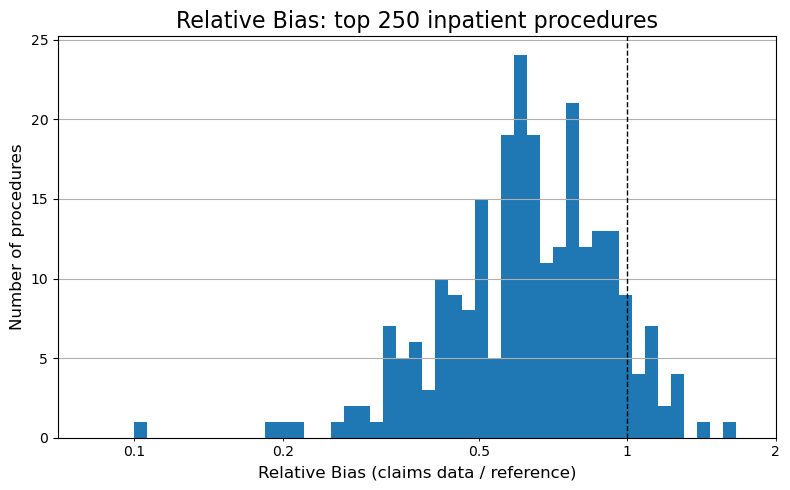

In [113]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

weights = np.ones(250) #/ 2.5
df_procs.sort_values(by = 'rate_SID', ascending=False)[1:251].rel_bias.hist(
    weights=weights,
    bins=np.logspace(np.log10(0.1),np.log10(2.0), 50),
    ax=ax)

plt.xscale('log')

plt.xlabel('Relative Bias (claims data / reference)', fontsize=12)
plt.ylabel('Number of procedures', fontsize=12)

plt.title('Relative Bias: top 250 inpatient procedures', fontsize=16)

#plt.gca().set_xscale("log")
plt.axvline(1,linestyle='--', color='k', lw=1)
plt.xlim([0.07, 2])

ax = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

ax.xaxis.set_minor_locator(ticker.FixedLocator(locs))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
ax.xaxis.set_major_locator(ticker.NullLocator())

plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)
plt.show()

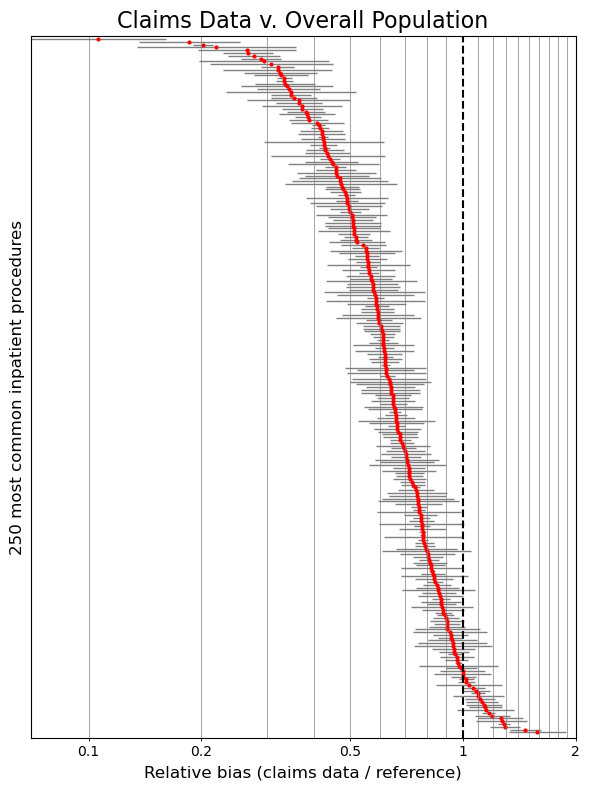

In [71]:
plt.figure(figsize=(6,8))

df_temp = df_procs.sort_values(by = 'rate_SID', ascending=False)[1:251].sort_values(by='rel_bias').copy()

err = np.array([np.array(df_temp['rel_bias']        - df_temp['rel_bias_low'])  ,
                np.array(df_temp['rel_bias_high']   - df_temp['rel_bias'])   ])

plt.scatter(df_temp['rel_bias'],df_temp['procedure'],  s=4, zorder=2,
             color='red')
plt.barh(df_temp['procedure'], df_temp['rel_bias'], xerr=err, facecolor='none', 
         error_kw=dict(lw=1, capsize=0, capthick=0, ecolor='gray'), zorder=1)


plt.xscale('log')
plt.gca().invert_yaxis()

plt.xlabel('Relative bias (claims data / reference)', fontsize=12)
plt.ylabel('250 most common inpatient procedures', fontsize=12)

plt.title('Claims Data v. Overall Population', fontsize=16)

plt.axvline(1,linestyle='--', color='k', lw=1.5)
plt.axvline(.1, color='gray', linewidth=0.5)
plt.axvline(.2, color='gray', linewidth=0.5)
plt.axvline(.3, color='gray', linewidth=0.5)
plt.axvline(.4, color='gray', linewidth=0.5)
plt.axvline(.5, color='gray', linewidth=0.5)
plt.axvline(.6, color='gray', linewidth=0.5)
plt.axvline(.7, color='gray', linewidth=0.5)
plt.axvline(.8, color='gray', linewidth=0.5)
plt.axvline(.9, color='gray', linewidth=0.5)
plt.axvline(1.1, color='gray', linewidth=0.5)
plt.axvline(1.2, color='gray', linewidth=0.5)
plt.axvline(1.3, color='gray', linewidth=0.5)
plt.axvline(1.4, color='gray', linewidth=0.5)
plt.axvline(1.5, color='gray', linewidth=0.5)
plt.axvline(1.6, color='gray', linewidth=0.5)
plt.axvline(1.7, color='gray', linewidth=0.5)
plt.axvline(1.8, color='gray', linewidth=0.5)
plt.axvline(1.9, color='gray', linewidth=0.5)
plt.axvline(2.0, color='gray', linewidth=0.5)
plt.axvline(2.1, color='gray', linewidth=0.5)
plt.axvline(2.2, color='gray', linewidth=0.5)
plt.axvline(2.3, color='gray', linewidth=0.5)
plt.axvline(2.4, color='gray', linewidth=0.5)
plt.xlim([0.1, 2])

plt.ylim([251, -1])
plt.xlim([.07, 2])

ax = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

ax.xaxis.set_minor_locator(ticker.FixedLocator(locs))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
ax.xaxis.set_major_locator(ticker.NullLocator())

ax.yaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_minor_locator(ticker.NullLocator())

plt.tight_layout()
plt.savefig('temp.jpg', dpi = 400)
plt.show()

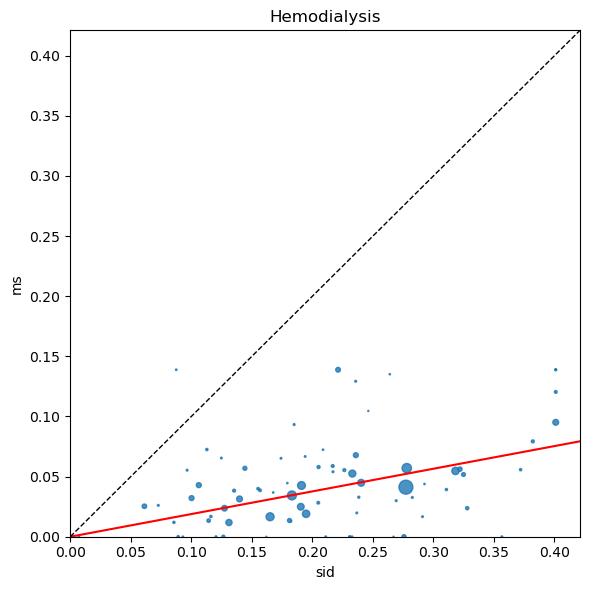

In [67]:
#make a scatter plot comparing rates for a given procedure

proc = 'Hemodialysis'
upper_clip = 95

#proc = 'Fetal heart rate monitoring'

df_temp = pd.merge(df_sid[['MSA', 'EGEOLOC', proc]], df[['MSA', 'EGEOLOC', proc, 'Total Pop']], on=['MSA', 'EGEOLOC']).rename(columns = {proc+'_x': 'sid', proc+'_y': 'ms'})


df_temp['sid'] = df_temp.sid.clip(upper = np.percentile(df_temp.sid, upper_clip))
df_temp['ms'] = df_temp.ms.clip(upper = np.percentile(df_temp.ms, upper_clip))

plot_max = max(df_temp.sid.max(), df_temp.ms.max())*1.05

plt.figure(figsize=(6,6))
plt.title(proc)
sns.regplot(x=df_temp.sid, y=df_temp.ms,  scatter_kws={'s': df_temp['Total Pop']/100000}, fit_reg=False)
plt.ylim([0,plot_max])
plt.xlim([0,plot_max])

est = sm.WLS(df_temp.ms, df_temp.sid, weights=df_temp['Total Pop']).fit()
slope = est.params['sid']
x_vals = np.array(plt.xlim())
y_vals = slope * x_vals
plt.plot(x_vals, y_vals, 'r-')


xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)

plt.tight_layout()
plt.savefig('temp.jpg')
plt.show()

In [47]:
df_temp.to_csv('procedure_rates_2019.csv')

# Determine zip code association between SES and procedure rate

In [72]:
df_ses = pd.read_csv('census_zip_2019_with_pca_and_ndi.csv')
df_ses

,Unnamed: 0,zip,Total Pop,Square Miles,frac_female,frac_white,frac_black,frac_hispanic,frac_asian,frac_other,...,County Code,County,State Code,State,pop_density,total_pop_millions,log_10_pop_density,house_price_millions,SES,NDI
0,0,35228,10293.143006,4.485270,0.553400,0.057527,0.857561,0.062580,0.001179,0.021153,...,73,Jefferson,1,Alabama,2294.876937,0.004781,3.036564,0.0855,-4.224270,1.263236
1,1,35214,17072.143160,33.164212,0.557357,0.206600,0.749724,0.019214,0.008430,0.016031,...,73,Jefferson,1,Alabama,514.776087,0.001946,3.352320,0.0678,-1.617630,0.551203
2,2,35204,10312.324334,4.700888,0.528552,0.048820,0.894343,0.046149,0.002804,0.007884,...,73,Jefferson,1,Alabama,2193.697256,0.004080,3.467169,0.0684,-5.228271,1.478569
3,3,35234,5439.930425,2.305478,0.553772,0.101442,0.879663,0.015966,0.001799,0.001130,...,73,Jefferson,1,Alabama,2359.566944,0.005291,3.625690,0.0641,-5.144553,1.484304
4,4,35210,14633.232997,20.925082,0.554609,0.622672,0.280717,0.052337,0.003810,0.040465,...,73,Jefferson,1,Alabama,699.315445,0.002533,3.444273,0.0673,0.540388,-0.230508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33555,33555,82215,309.387097,163.723831,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,...,31,Platte,56,Wyoming,1.889689,0.001622,1.023097,0.0813,-0.094913,-0.244544
33556,33556,82214,35.870968,18.982473,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,...,31,Platte,56,Wyoming,1.889689,0.002051,1.581576,0.0952,-0.082030,-0.244544
33557,33557,82213,941.612903,498.289919,0.495204,0.920264,0.000600,0.059952,0.000000,0.019185,...,31,Platte,56,Wyoming,1.889689,0.002312,1.093418,0.1164,-0.089438,-0.244544
33558,33558,82059,209.444344,49.801033,0.479818,0.932888,0.000000,0.042513,0.000000,0.024600,...,21,Laramie,56,Wyoming,4.205622,0.003400,1.892861,0.1083,3.699783,-0.888475


In [73]:
df_procs 

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high
0,"Abdominal wall procedures, NEC",0.011124,0.000697,0.016563,0.000020,0.671625,0.594035,0.759350
1,Abdominal wall repair (including hernia),0.032152,0.001184,0.043635,0.000032,0.736833,0.685501,0.792010
2,Above knee and other proximal lower extremity ...,0.001178,0.000227,0.003828,0.000010,0.307730,0.211028,0.448746
3,"Administration and transfusion of bone marrow,...",0.006936,0.000550,0.005463,0.000011,1.269637,1.086802,1.483231
4,Administration of albumin and globulin,0.006107,0.000516,0.010641,0.000016,0.573945,0.486316,0.677365
...,...,...,...,...,...,...,...,...
290,Vertebral discectomy,0.066484,0.001703,0.073989,0.000042,0.898566,0.854555,0.944843
291,Vessel repair and replacement,0.013567,0.000769,0.018111,0.000021,0.749121,0.670307,0.837201
292,Vulvar laceration repair,0.063910,0.001670,0.083772,0.000045,0.762906,0.724815,0.802999
294,Male perineum procedures,0.001658,0.000269,0.001491,0.000006,1.112112,0.809135,1.528537


In [74]:
procs = list(df_procs.sort_values(by = 'rate_SID', ascending=False)[1:251].procedure)

In [75]:
df_counts = pd.read_csv('SID_zip_counts.csv')

In [76]:
df_counts.ZIP.nunique()

16612

In [129]:
# You have 2 choices of which inequality measure to use.  You can use the National Deprivation Index (NDI)
# or you can use the SES metric we defined using PCA (SES).

inequality_measure = 'SES'


df_procs_250 = pd.DataFrame([], columns=['procedure', 'rate_MS', 'err_rate_MS', 'rate_SID', 'err_rate_SID', 'rel_bias', 'rel_bias_low', 'rel_bias_high', 'corr_ses', 'intercept_ses', 'slope_ses', 'slope_ses_se', 'alpha'])

def ct_response(row):
    #“Calculate response observation for Cameron-Trivedi dispersion test”
    y = row[case_col]
    m = row['bev_mu']
    return ((y - m)**2 - y) / m

i=0
for proc in procs: 
    df_tt = pd.merge(df_ses, df_counts[df_counts['PRCCSR DESCRIPTION'] == proc], left_on='zip', right_on='ZIP', how='left')
    df_tt['Pop 18 - 64'] = df_tt['Total Pop'] * (df_tt['frac_18_to_39'] + df_tt['frac_40_to_64'])
    df_tt['sid_rate'] = df_tt['count'].fillna(0) / df_tt['Pop 18 - 64']
    
 #   df_tt['phat'] = df_tt['sid_rate'].clip(lower = np.percentile(df_tt[df_tt['sid_rate']>0]['sid_rate'], 5),
 #                                    upper = np.percentile(df_tt[df_tt['sid_rate']>0]['sid_rate'], 95))
    df_tt['weight'] =  df_tt['Pop 18 - 64'] 
    
    ses_corr = corr(df_tt['sid_rate'], df_tt[inequality_measure], df_tt['weight'])
    

    y = df_tt['count'].fillna(0)
    X = sm.add_constant(df_tt[inequality_measure])

    res = sm.GLM(y, X,
        family=sm.families.Poisson(),
        offset = np.log(df_tt['weight']) 
    ).fit()
    
    ct_data = df_tt.copy()
    ct_data['bev_mu'] = res.mu
    case_col = 'count'
    ct_data['ct_resp'] = ct_data.apply(ct_response, axis=1)
    ct_results = smf.ols('ct_resp ~ bev_mu - 1', ct_data).fit()
    alpha_ci95 = ct_results.conf_int(0.05).loc['bev_mu']
    alpha0 = ct_results.params['bev_mu']

    est = sm.GLM(y, X,
        family=sm.families.Poisson(),
        #family=sm.families.NegativeBinomial(alpha = alpha0),
        offset = np.log(df_tt['weight']) 
    ).fit()
    
    intercept = est.params['const']
    slope = est.params[inequality_measure]
    slope_se =  est.bse[inequality_measure]
    
    
    df_procs_250.loc[i] = list(df_procs[df_procs.procedure == proc].values[0]) + [ses_corr, intercept, slope, slope_se, alpha0]
    i += 1

In [130]:
#df_procs_250.to_csv('temp.csv')

In [131]:
df_procs_250['quartile'] = 'Q1'
df_procs_250.loc[df_procs_250.slope_ses > np.percentile(df_procs_250.slope_ses, 20), 'quartile'] = 'Q2'
df_procs_250.loc[df_procs_250.slope_ses > np.percentile(df_procs_250.slope_ses, 40), 'quartile'] = 'Q3'
df_procs_250.loc[df_procs_250.slope_ses > np.percentile(df_procs_250.slope_ses, 60), 'quartile'] = 'Q4'
df_procs_250.loc[df_procs_250.slope_ses > np.percentile(df_procs_250.slope_ses, 80), 'quartile'] = 'Q5'

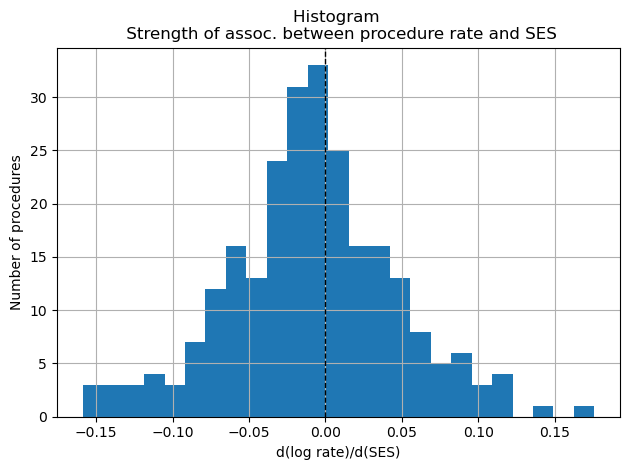

In [132]:
df_procs_250.slope_ses.hist(bins=25)

plt.axvline(0,linestyle='--', color='k', lw=1)

plt.title('Histogram \n Strength of assoc. between procedure rate and SES')

plt.xlabel('d(log rate)/d(SES)')
plt.ylabel('Number of procedures')
plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)
plt.show()

In [133]:
df_procs_250.slope_ses.describe()

count    250.000000
mean      -0.009072
std        0.055488
min       -0.158917
25%       -0.039242
50%       -0.009092
75%        0.022229
max        0.175989
Name: slope_ses, dtype: float64

In [134]:
np.percentile(df_procs_250.slope_ses, 5)

-0.10763732940234767

In [135]:
np.percentile(df_procs_250.slope_ses, 95)

0.08662996985224487

In [136]:
df_procs_250[df_procs_250.quartile == 'Q1'].sort_values(by='rate_SID', ascending=True)[-5:]

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high,corr_ses,intercept_ses,slope_ses,slope_ses_se,alpha,quartile
14,Airway intubation,0.058545,0.001598,0.175402,0.000065,0.333774,0.316384,0.352120,-0.076696,-7.867953,-0.069525,0.001311,12.785965,Q1
11,Hemodialysis,0.046024,0.001417,0.227821,0.000074,0.202019,0.190188,0.214586,-0.144610,-7.639991,-0.151976,0.001188,18.475396,Q1
10,Mechanical ventilation,0.076300,0.001824,0.228758,0.000074,0.333540,0.318267,0.349545,-0.074427,-7.597072,-0.066856,0.001144,11.271724,Q1
6,Transfusion of blood and blood products,0.145576,0.002520,0.340988,0.000090,0.426925,0.412681,0.441661,-0.062196,-7.201824,-0.055992,0.000937,13.360746,Q1
4,Venous and arterial catheter placement,0.181436,0.002813,0.429508,0.000101,0.422427,0.409781,0.435465,-0.066436,-6.974210,-0.055903,0.000835,10.520605,Q1


In [137]:
df_procs_250[df_procs_250.quartile == 'Q3'].sort_values(by='rate_SID', ascending=False)[0:5]

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high,corr_ses,intercept_ses,slope_ses,slope_ses_se,alpha,quartile
3,Fetal heart rate monitoring,0.266897,0.003412,0.429708,0.000101,0.621113,0.605740,0.636877,-0.004317,-6.997012,-0.004512,0.000830,35.833149,Q3
20,"Administration of therapeutic substances, NEC",0.059941,0.001617,0.107145,0.000050,0.559437,0.530620,0.589818,-0.011450,-8.363372,-0.011626,0.001648,26.257539,Q3
32,Gastrectomy,0.088820,0.001968,0.080846,0.000044,1.098638,1.051924,1.147427,-0.001295,-8.655895,-0.001255,0.001899,17.819487,Q3
35,Salpingectomy,0.060333,0.001622,0.077938,0.000043,0.774116,0.734365,0.816018,-0.005956,-8.698491,-0.005350,0.001944,16.851360,Q3
40,Lumbar puncture,0.039481,0.001312,0.064451,0.000039,0.612564,0.573920,0.653810,-0.023438,-8.866868,-0.020610,0.002128,14.321708,Q3


In [138]:
df_procs_250[df_procs_250.quartile == 'Q5'].sort_values(by='rate_SID', ascending=False)[0:5]

,procedure,rate_MS,err_rate_MS,rate_SID,err_rate_SID,rel_bias,rel_bias_low,rel_bias_high,corr_ses,intercept_ses,slope_ses,slope_ses_se,alpha,quartile
2,Assisted vaginal delivery,0.373429,0.004036,0.478625,0.000107,0.780212,0.763854,0.796921,0.043191,-6.907424,0.034841,0.000779,15.274612,Q5
5,Perineal muscle laceration repair (2nd degree ...,0.345509,0.003882,0.355711,0.000092,0.971320,0.950156,0.992955,0.140954,-7.281799,0.107532,0.000901,12.078481,Q5
8,Intravenous induction of labor,0.193302,0.002904,0.246753,0.000077,0.783384,0.760649,0.806798,0.044848,-7.571982,0.037446,0.001085,14.816763,Q5
22,Spine fusion,0.093794,0.002023,0.098381,0.000048,0.953365,0.913896,0.994539,0.043658,-8.469099,0.040771,0.001696,9.605691,Q5
26,Knee arthroplasty,0.102606,0.002116,0.087586,0.000046,1.171489,1.125074,1.219820,0.055408,-8.608960,0.053722,0.001806,10.642670,Q5


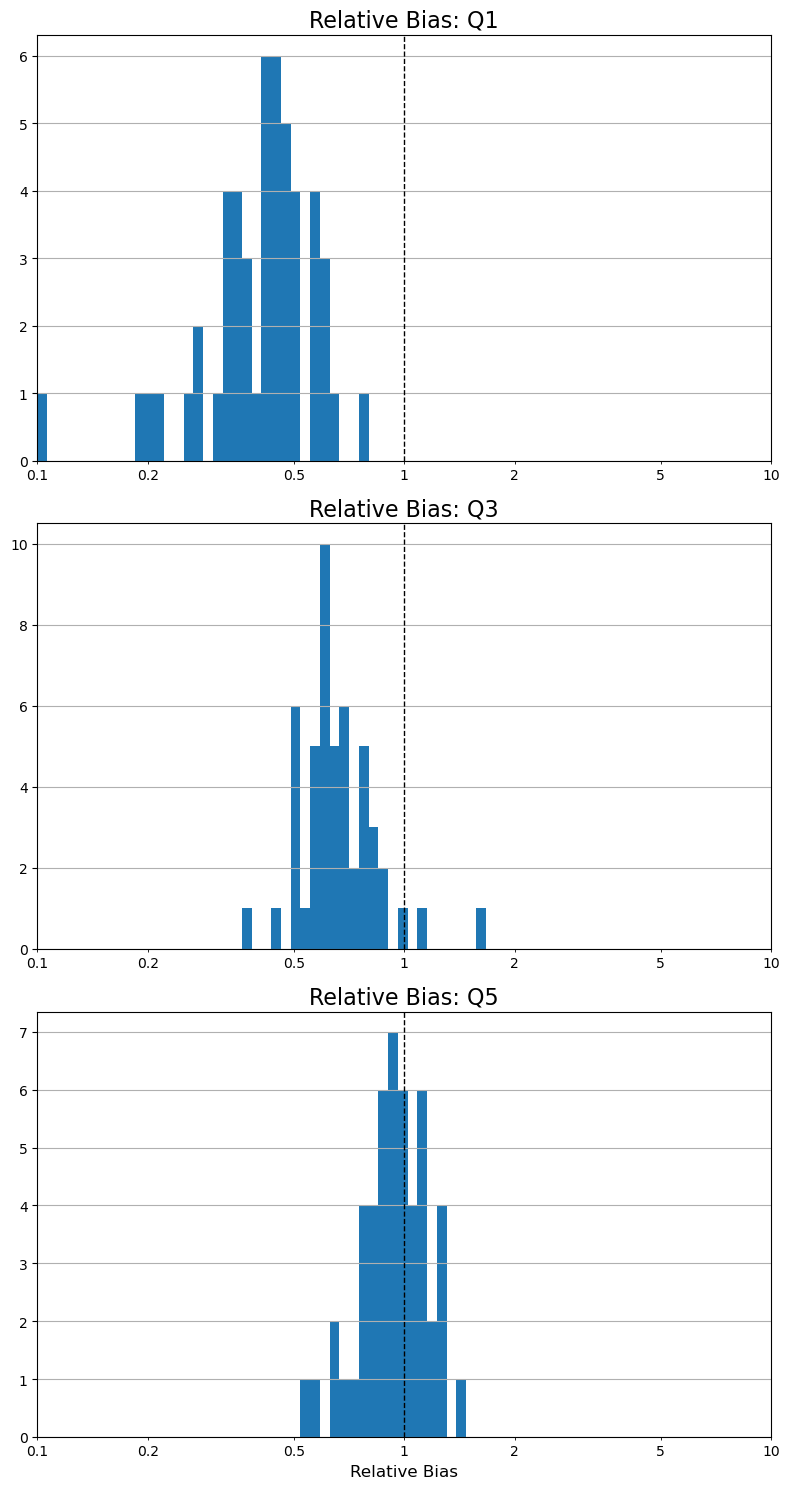

In [139]:
fig, axes = plt.subplots(3,1,figsize=(8,15))


plt.subplot(3,1,1)

#weights = np.ones(50) / 2.5
df_procs_250[df_procs_250.quartile=='Q1'].rel_bias.hist(
    #weights=weights,
    bins=np.logspace(np.log10(0.1),np.log10(2.0), 50),
    ax=axes[0])

axes[0].set_xscale('log')
axes[0].set_title('Relative Bias: Q1', fontsize=16)

#plt.gca().set_xscale("log")
plt.axvline(1,linestyle='--', color='k', lw=1)
plt.xlim([0.1, 10])

axes[0] = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

axes[0].xaxis.set_minor_locator(ticker.FixedLocator(locs))
axes[0].xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
axes[0].xaxis.set_major_locator(ticker.NullLocator())




plt.subplot(3,1,2)

#weights = np.ones(50) / 2.5
df_procs_250[df_procs_250.quartile=='Q3'].rel_bias.hist(
    #weights=weights,
    bins=np.logspace(np.log10(0.1),np.log10(2.0), 50),
    ax=axes[1])

axes[1].set_xscale('log')
axes[1].set_title('Relative Bias: Q3', fontsize=16)

plt.axvline(1,linestyle='--', color='k', lw=1)
plt.xlim([0.1, 10])

axes[1] = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

axes[1].xaxis.set_minor_locator(ticker.FixedLocator(locs))
axes[1].xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
axes[1].xaxis.set_major_locator(ticker.NullLocator())




plt.subplot(3,1,3)

#weights = np.ones(50) / 2.5
df_procs_250[df_procs_250.quartile=='Q5'].rel_bias.hist(
    #weights=weights,
    bins=np.logspace(np.log10(0.1),np.log10(2.0), 50),
    ax=axes[2])

axes[2].set_xscale('log')

plt.xlabel('Relative Bias', fontsize=12)
plt.ylabel('', fontsize=12)

plt.title('Relative Bias: Q5', fontsize=16)

#plt.gca().set_xscale("log")
plt.axvline(1,linestyle='--', color='k', lw=1)
plt.xlim([0.1, 10])

axes[2] = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

axes[2].xaxis.set_minor_locator(ticker.FixedLocator(locs))
axes[2].xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
axes[2].xaxis.set_major_locator(ticker.NullLocator())

plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)
plt.show()

In [140]:
df_procs_250.sort_values(by = 'slope_ses', ascending=True)[:10] [['procedure', 'rel_bias', 'slope_ses']]

,procedure,rel_bias,slope_ses
198,Peripheral arteriovenous fistula and shunt pro...,0.339681,-0.158917
11,Hemodialysis,0.202019,-0.151976
239,Finger and other upper extremity amputation,0.219266,-0.148701
192,"Administration of diagnostic substances, NEC",0.264752,-0.140529
170,Cardiac stress tests,0.185821,-0.140291
188,Arterial oxygen saturation monitoring,0.371642,-0.136658
230,Above knee and other proximal lower extremity ...,0.307730,-0.128620
222,"Physical, occupational, and respiratory therap...",0.758097,-0.126112
173,Subcutaneous contraceptive implant,0.106292,-0.119986
246,Eye procedures,0.472402,-0.118463


In [141]:
#df_temp = df_procs_250.sort_values(by='rate_SID')[-100:].copy() 

#df_temp = df_procs_250[(~df_procs_250.procedure.str.contains('sycho')) 
#             & (~df_procs_250.procedure.str.contains('ental health')) ].copy()

df_temp=df_procs_250.copy()
df_temp['log_rel_bias'] = np.log(df_temp.rel_bias)

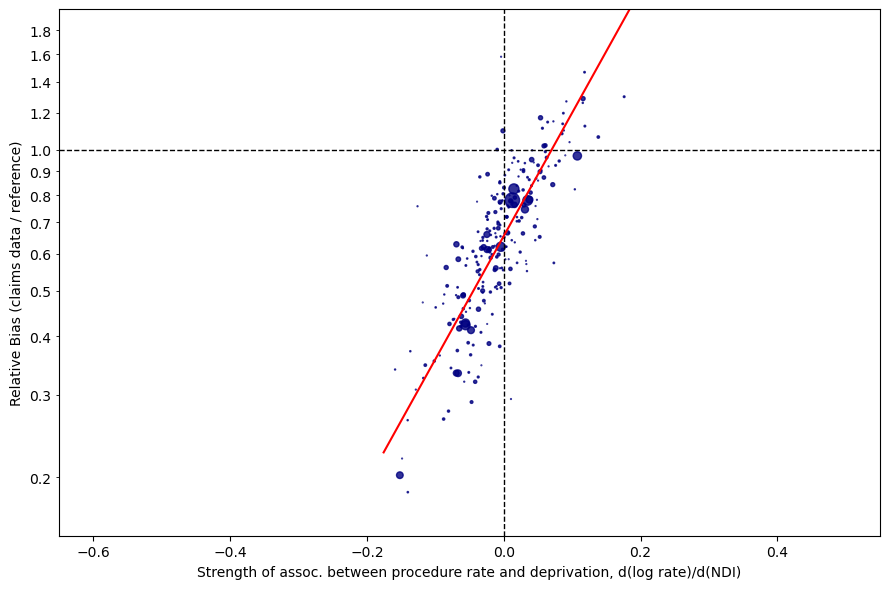

In [142]:
fig, ax = plt.subplots(1,1,figsize=(9,6))

sns.regplot(y='rel_bias', x = 'slope_ses', data=df_temp,
            scatter_kws={'s': df_temp['rate_SID']*100,  'color':'navy'}, fit_reg = False)

#ax.errorbar(x=df_temp['slope_ses'], y=df_temp['log_rel_bias'], 
#            xerr=1.96*df_temp['slope_ses_se'], 
#            yerr=df_temp['log_rel_bias'] - np.log(df_temp['rel_bias_low']), 
#            fmt='none', capsize=2, color='k')

#sns.regplot(y='log_rel_bias', x = 'slope_ses', data=df_temp,
#            scatter_kws={'s': 3,  'color':'red', 'zorder':4}, fit_reg = False)

plt.axhline(1,linestyle='--', color='k', lw=1,)
plt.axvline(0,linestyle='--', color='k', lw=1,)

ax.set_yscale('log')

est = sm.WLS(exog = sm.add_constant(df_temp['slope_ses']),
             endog = df_temp.log_rel_bias,
             #weights=df_temp['rate_SID']
             weights=df_temp['slope_ses_se']**-2).fit()
intercept = est.params['const']
slope = est.params['slope_ses']
x_vals = np.array(plt.xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, np.exp(y_vals), 'r-')

plt.xlim([-0.65, 0.55])
#plt.xlim([-0.21, 0.21])
plt.ylim([0.15, 2.0])

locs = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.2, 1.4, 1.6, 1.8])
labels = np.array(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', '1.2', '1.4', '1.6', '1.8'])

ax.yaxis.set_minor_locator(ticker.FixedLocator(locs))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter(labels))
ax.yaxis.set_major_locator(ticker.NullLocator())

#plt.title('Procedures with more bias occur disproportionately in lower SES zip codes', size=14)

plt.xlabel('Strength of assoc. between procedure rate and deprivation, d(log rate)/d(NDI)')

plt.ylabel('Relative Bias (claims data / reference)')
plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)
plt.show()

In [143]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:           log_rel_bias   R-squared:                       0.739
Model:                            WLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     700.7
Date:                Mon, 03 Mar 2025   Prob (F-statistic):           3.27e-74
Time:                        17:34:17   Log-Likelihood:                -41.359
No. Observations:                 250   AIC:                             86.72
Df Residuals:                     248   BIC:                             93.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4229      0.012    -35.745      0.000      -0.446      -0.400
slope_ses      6.0597      0.229     26.472      0.000       5.609       6.511
==============================================================================
Omnibus:                       22.515   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.943
Skew:                          -0.157   Prob(JB):                     5.92e-19
Kurtosis:                       5.821   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
plt.figure(figsize=(5,10))

df_temp = df_procs_250.sort_values(by='rel_bias').copy()

err = np.array([np.array(df_temp['rel_bias']        - df_temp['rel_bias_low'])  ,
                np.array(df_temp['rel_bias_high']   - df_temp['rel_bias'])   ])

plt.scatter(df_temp['rel_bias'],df_temp['procedure'],  s=8, zorder=2,
            c = df_temp['corr_ses'] / .15,
           cmap = 'PiYG')
            # color='k')
plt.barh(df_temp['procedure'], df_temp['rel_bias'], xerr=err, facecolor='none', 
         error_kw=dict(lw=1, capsize=0, capthick=0, ecolor='gray'), zorder=1)


plt.xscale('log')
plt.gca().invert_yaxis()

plt.xlabel('Relative Bias', fontsize=12)
plt.ylabel('250 most common inpatient procedures', fontsize=12)

plt.title('External Validity Bias', fontsize=16)


plt.axvline(1,linestyle='--', color='k', lw=1.5)
#plt.axvline(df_procs[df_procs.procedure == 'Overall Inpatient Visits'].rel_bias.values[0],linestyle=':', color='gray', lw=1)
plt.axvline(.2, color='gray', linewidth=0.5)
plt.axvline(.3, color='gray', linewidth=0.5)
plt.axvline(.4, color='gray', linewidth=0.5)
plt.axvline(.5, color='gray', linewidth=0.5)
plt.axvline(.6, color='gray', linewidth=0.5)
plt.axvline(.7, color='gray', linewidth=0.5)
plt.axvline(.8, color='gray', linewidth=0.5)
plt.axvline(.9, color='gray', linewidth=0.5)
plt.axvline(1.1, color='gray', linewidth=0.5)
plt.axvline(1.2, color='gray', linewidth=0.5)
plt.axvline(1.3, color='gray', linewidth=0.5)
plt.axvline(1.4, color='gray', linewidth=0.5)
plt.axvline(1.5, color='gray', linewidth=0.5)
plt.axvline(1.6, color='gray', linewidth=0.5)
plt.axvline(1.7, color='gray', linewidth=0.5)
plt.axvline(1.8, color='gray', linewidth=0.5)
plt.axvline(1.9, color='gray', linewidth=0.5)
plt.axvline(2.0, color='gray', linewidth=0.5)
plt.axvline(2.1, color='gray', linewidth=0.5)
plt.axvline(2.2, color='gray', linewidth=0.5)
plt.axvline(2.3, color='gray', linewidth=0.5)
plt.axvline(2.4, color='gray', linewidth=0.5)
plt.xlim([0.1, 2])

plt.ylim([251, -1])

ax = plt.gca()
locs = np.array([.1, 0.2, 0.5,  1, 2, 5, 10])
labels = np.array(['0.1', '0.2', '0.5', '1', '2', '5','10'])

ax.xaxis.set_minor_locator(ticker.FixedLocator(locs))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(labels))
ax.xaxis.set_major_locator(ticker.NullLocator())

ax.yaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_minor_locator(ticker.NullLocator())

plt.tight_layout()
plt.savefig('temp.jpg', dpi = 400)

In [145]:
df_procs_250.to_csv('procs_250.csv')

In [208]:
df_temp = pd.merge(df_procs_250, df_pccrs, left_on='procedure', right_on = 'PRCCSR DESCRIPTION')
df_codes = pd.DataFrame([], columns = ['procedure', 'PRCCSR code', 'ICD-10-PCS codes'])
ii = 0
for proc in set(df_temp.procedure):
    PRCCSR_code = df_temp[df_temp.procedure==proc].reset_index().PRCCSR[0]
    ICD_PCS_codes = ', '.join(df_temp[df_temp.procedure==proc]['ICD-10-PCS'])
    df_codes.loc[ii] = [proc, PRCCSR_code, ICD_PCS_codes]
    ii += 1
df_codes

,procedure,PRCCSR code,ICD-10-PCS codes
0,Cardiac stress tests,MAM004,"4A02XM4, 4A12XM4"
1,Fixation of leg and foot bones,MST011,"0QHD04Z, 0QHD05Z, 0QHD34Z, 0QHD35Z, 0QHD44Z, 0..."
2,ENT repair,ENT013,"09Q00ZZ, 09Q03ZZ, 09Q04ZZ, 09Q0XZZ, 09Q10ZZ, 0..."
3,Above knee and other proximal lower extremity ...,MST025,"0Y620ZZ, 0Y630ZZ, 0Y640ZZ, 0Y670ZZ, 0Y680ZZ, 0..."
4,Planar nuclear medicine imaging,NCM001,"C0101ZZ, C010YZZ, C015DZZ, C015YZZ, C01YYZZ, C..."
...,...,...,...
245,Administration of thrombolytics and platelet i...,ADM005,"3E03016, 3E03017, 3E030PZ, 3E03316, 3E03317, 3..."
246,GI system repair (excluding anorectal),GIS021,"0DQ10ZZ, 0DQ13ZZ, 0DQ14ZZ, 0DQ17ZZ, 0DQ18ZZ, 0..."
247,"Mediastinal procedures, NEC",GNR007,"0W2CX0Z, 0W2CXYZ, 0W9C00Z, 0W9C0ZX, 0W9C0ZZ, 0..."
248,Pheresis therapy,EST001,"6A550Z0, 6A550Z1, 6A550Z2, 6A550Z3, 6A550ZT, 6..."


In [209]:
df_codes.to_csv('codes.csv')

In [235]:
set(df_codes['PRCCSR code'])

{'ADM001',
 'ADM002',
 'ADM003',
 'ADM005',
 'ADM006',
 'ADM007',
 'ADM008',
 'ADM009',
 'ADM010',
 'ADM011',
 'ADM012',
 'ADM013',
 'ADM015',
 'ADM016',
 'ADM017',
 'ADM018',
 'ADM020',
 'ADM021',
 'CAR002',
 'CAR003',
 'CAR004',
 'CAR006',
 'CAR007',
 'CAR008',
 'CAR009',
 'CAR010',
 'CAR011',
 'CAR012',
 'CAR014',
 'CAR015',
 'CAR017',
 'CAR019',
 'CAR020',
 'CAR022',
 'CAR023',
 'CAR024',
 'CAR025',
 'CAR026',
 'CAR027',
 'CAR028',
 'CAR029',
 'CNS001',
 'CNS002',
 'CNS003',
 'CNS004',
 'CNS005',
 'CNS006',
 'CNS007',
 'CNS008',
 'CNS009',
 'CNS010',
 'CNS011',
 'CNS012',
 'CNS014',
 'ENP002',
 'ENP005',
 'ENT001',
 'ENT002',
 'ENT003',
 'ENT006',
 'ENT008',
 'ENT012',
 'ENT013',
 'ENT015',
 'ENT017',
 'ESA001',
 'ESA002',
 'ESA003',
 'ESA004',
 'ESA005',
 'ESA006',
 'ESA007',
 'ESA008',
 'ESA009',
 'ESA010',
 'EST001',
 'EYP001',
 'EYP002',
 'FRS001',
 'FRS002',
 'FRS003',
 'FRS004',
 'FRS005',
 'FRS006',
 'FRS007',
 'FRS008',
 'FRS010',
 'FRS011',
 'FRS012',
 'FRS013',
 'FRS015',

# Study MarketScan Coverage in 2019

In [3]:
df_census = pd.read_csv('msa_census_2018.csv')

In [4]:
xls = pd.ExcelFile('marketscan_counts.xlsx')

# Now you can list all sheets in the file
xls.sheet_names

['mem_days', 'hip_replacements', 'mem_days_medi', 'hip_replacements_medi']

In [5]:
df1 = pd.read_excel(xls, 'mem_days')
df2 = pd.read_excel(xls, 'hip_replacements')
df3 = pd.read_excel(xls, 'mem_days_medi')
df4 = pd.read_excel(xls, 'hip_replacements_medi')

In [6]:
df_comm = pd.merge(df1, df2, how='outer', on=['EGEOLOC', 'MSA']).rename(columns={'mem_days':'mem_days_comm', 'count':'hip_replacements_comm'})
df_medi = pd.merge(df3, df4, how='outer', on=['EGEOLOC', 'MSA']).rename(columns={'mem_days':'mem_days_medi', 'hip_replacements':'hip_replacements_medi'})

df_ms = pd.merge(df_comm, df_medi, how='outer', on=['EGEOLOC', 'MSA'])

df_ms['hip_rate_comm'] = (df_ms.hip_replacements_comm / df_ms.mem_days_comm).fillna(0) * 36500
df_ms['hip_rate_medi'] = (df_ms.hip_replacements_medi / df_ms.mem_days_medi).fillna(0) * 36500
df_ms['hip_rate_ms'] = ((df_ms.hip_replacements_comm + df_ms.hip_replacements_medi) / (df_ms.mem_days_comm + df_ms.mem_days_medi)).fillna(0) * 36500

In [7]:
df_ms[df_ms.EGEOLOC==1]

,MSA,EGEOLOC,mem_days_comm,hip_replacements_comm,mem_days_medi,hip_replacements_medi,hip_rate_comm,hip_rate_medi,hip_rate_ms
2,34820.0,1,6964784.0,NaN,2555.0,NaN,0.0,0.0,0.0
3,0.0,1,156667386.0,NaN,19364446.0,NaN,0.0,0.0,0.0
4,22900.0,1,733379.0,NaN,730.0,NaN,0.0,0.0,0.0
5,23580.0,1,495736.0,NaN,730.0,NaN,0.0,0.0,0.0
6,12260.0,1,18198797.0,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
706,48300.0,1,NaN,NaN,881.0,NaN,0.0,0.0,0.0
707,48900.0,1,NaN,NaN,6175.0,NaN,0.0,0.0,0.0
708,49180.0,1,NaN,NaN,6813.0,NaN,0.0,0.0,0.0
709,49340.0,1,NaN,NaN,5536.0,NaN,0.0,0.0,0.0


In [9]:
df_ms['mem_days_comm'].sum() / (df_census['Total Pop'] *  (1-df_census.frac_over_65)).sum() / 365 * 100

6.7124427135613995

In [10]:
df_ms[(df_ms.MSA.isna()) | (df_ms.EGEOLOC == 1)].mem_days_comm.sum() / df_ms.mem_days_comm.sum() * 100

13.574582973932491

In [11]:
df_ms['mem_days_medi'].sum() / (df_census['Total Pop'] *  (df_census.frac_over_65)).sum() / 365 * 100

1.1770184031591049

In [12]:
df_ms[(df_ms.MSA.isna()) | (df_ms.EGEOLOC == 1)].mem_days_medi.sum() / df_ms.mem_days_medi.sum() * 100

62.89505865631183

In [14]:
df = pd.merge(df_census, df_ms, on=['MSA', 'EGEOLOC'])

In [15]:
df['coverage_comm'] = df['mem_days_comm'] / df['Total Pop'] / (1-df.frac_over_65) / 365
df['coverage_medi'] = df['mem_days_medi'] / df['Total Pop'] / (df.frac_over_65) / 365

In [16]:
df.coverage_comm.fillna(0, inplace=True)
df.coverage_medi.fillna(0, inplace=True)

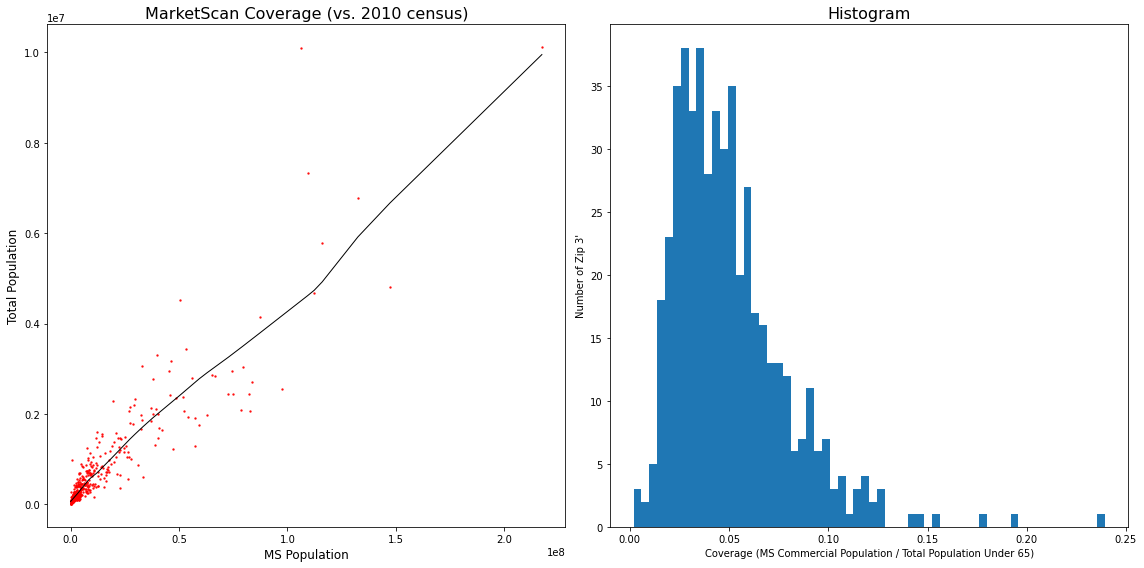

In [21]:
df_plot = df.copy()

plt.subplots(1,2,figsize=(16,8))

plt.subplot(1,2,1)
#plt.plot(df_plot['count']/1000, df_plot['Total Pop']/1000, '.', alpha = 0.25)
#plt.xlim([0,16000])
#plt.ylim([0,160000])
sns.regplot(x = 'mem_days_comm', y = 'Total Pop', data = df_plot, lowess=True, scatter_kws={'color':'r', 's':2}, line_kws={'color':'black', 'linewidth':'1'})
plt.xlabel('MS Population', fontsize=12)
plt.ylabel('Total Population', fontsize=12)
plt.title('MarketScan Coverage (vs. 2010 census)', fontsize=16)

plt.subplot(1,2,2)

plt.hist(df_plot[df_plot.coverage_comm < 1].coverage_comm, bins=60)
plt.title('Histogram', fontsize=16)
plt.xlabel('Coverage (MS Commercial Population / Total Population Under 65)')
plt.ylabel('Number of Zip 3\'')

plt.tight_layout()
#plt.savefig('coverage_MS.jpg')


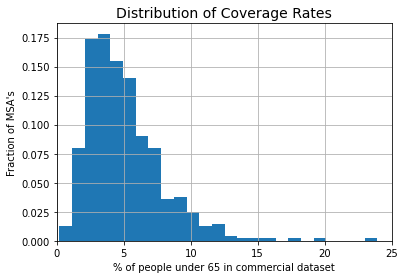

In [22]:
(100*df.coverage_comm).hist(bins=25, density=True)
plt.title('Distribution of Coverage Rates', fontsize=14)
plt.xlabel('% of people under 65 in commercial dataset')
plt.ylabel('Fraction of MSA\'s')
plt.xlim(0,25)

plt.savefig('temp.jpg', dpi=400)

In [23]:
df[['coverage_comm', 'Name', 'State Name']].sort_values(by='coverage_comm', ascending=False)

,coverage_comm,Name,State Name
225,0.239332,"Monroe, MI",Michigan
233,0.195240,"Ann Arbor, MI",Michigan
331,0.178601,"Toledo, OH",Ohio
79,0.154276,"Wilmington, DE-MD-NJ",Delaware
232,0.147975,"Midland, MI",Michigan
...,...,...,...
27,0.009652,"Pine Bluff, AR",Arkansas
53,0.009219,"El Centro, CA",California
125,0.002152,"Kahului-Wailuku-Lahaina, HI",Hawaii
124,0.001888,"Urban Honolulu, HI",Hawaii


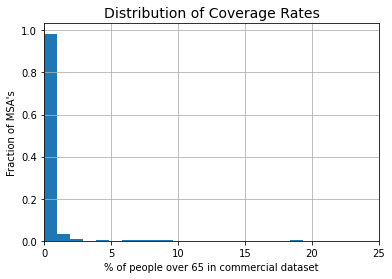

In [24]:
(100*df.coverage_medi).hist(bins=20,density=True)
plt.title('Distribution of Coverage Rates', fontsize=14)
plt.xlabel('% of people over 65 in commercial dataset')
plt.ylabel('Fraction of MSA\'s')
plt.xlim(0,25)

plt.savefig('temp.jpg', dpi=400)

In [26]:
df[['coverage_medi', 'Name', 'State Name']].sort_values(by='coverage_medi', ascending=False)

,coverage_medi,Name,State Name
233,0.193091,"Ann Arbor, MI",Michigan
225,0.095882,"Monroe, MI",Michigan
236,0.083179,"Battle Creek, MI",Michigan
230,0.075129,"Lansing-East Lansing, MI",Michigan
228,0.063518,"Grand Rapids-Wyoming, MI",Michigan
...,...,...,...
173,0.000000,"Davenport-Moline-Rock Island, IA-IL",Iowa
304,0.000000,"Utica-Rome, NY",New York
293,0.000000,"Albany-Schenectady-Troy, NY",New York
180,0.000000,"St. Joseph, MO-KS",Kansas


In [233]:
df[['coverage_comm', 'coverage_medi']].describe()

,coverage_comm,coverage_medi
count,502.000000,502.000000
mean,0.050266,0.003905
std,0.028563,0.011499
min,0.001878,0.000000
25%,0.029670,0.001183
50%,0.044706,0.001932
75%,0.063219,0.003504
max,0.239332,0.193091


In [241]:
np.percentile(df['coverage_medi'],5)

0.0003673705944335126

In [27]:
#what kind of MSA has more representation?

In [28]:
df['Total Pop 100k'] = df['Total Pop'] / 1000
df['Pop Density 1k'] = df['pop_density'] / 10
df['Log Pop Density'] = np.log10(df['pop_density']) / 100
df['Median House Price 100k'] = df['median_house_price'] / 1000

In [374]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [30]:
coverage_feature='coverage_comm'

df['phat'] = df[coverage_feature].clip(lower = np.percentile(df[coverage_feature], 10), upper = np.percentile(df[coverage_feature], 90))
df['weight'] = df['Total Pop']/df['phat']/(1-df['phat'])

In [31]:
features = ['Total Pop 100k', 'Log Pop Density',
          #  'Pop Density 1k',
    #'frac_female',  
            'frac_asian', 'frac_black', 'frac_hispanic', 'frac_white', 'frac_other',
                    'frac_under_18', 'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
     'frac_lt_20k', 'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k', 'frac_gt_200k', 
     'frac_unemployed', 'frac_no_health_insurance',
     'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college', 'frac_graduate',
     'frac_houses_owner_occupied', 
    'Median House Price 100k']

df_partial_corrs = pd.DataFrame([], columns = ['coef', 'std err', 'p', 'partial corr'])
i=0

for feature in features:
    
    print(feature)


    X = sm.add_constant(pd.get_dummies(df['State Name']).iloc[:,:-1]).astype(int)
    y = df[coverage_feature]*100
    weight = df['weight']

    est = sm.WLS(y, X, weights=weight).fit() 
    resid_Optum = est.resid


    y = df[feature]

    est = sm.WLS(y, X, weights = weight).fit() 
    resid_feature = est.resid

    X = sm.add_constant(df[feature])
    y = resid_Optum

    est = sm.WLS(y, X, weights = weight).fit() 

    results_as_html = est.summary().tables[1].as_html()
    temp = pd.read_html(results_as_html, header=0, index_col=0)[0]

    df_partial_corrs.loc[i] = list(temp.loc[feature,['coef', 'std err', 'P>|t|']]) + list([corr(resid_feature, resid_Optum, weight)])
    i += 1


Total Pop 100k
Log Pop Density
frac_asian
frac_black
frac_hispanic
frac_white
frac_other
frac_under_18
frac_18_to_39
frac_40_to_64
frac_over_65
frac_lt_20k
frac_20k_to_40k
frac_40k_to_75k
frac_75k_to_125k
frac_125k_to_200k
frac_gt_200k
frac_unemployed
frac_no_health_insurance
frac_lt_hs
frac_hs
frac_some_college
frac_college
frac_graduate
frac_houses_owner_occupied
Median House Price 100k


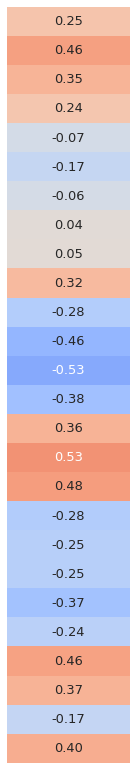

In [34]:
plt.figure(figsize=(2,10.8))


corr_mat =  df_partial_corrs[['partial corr']]

sns.heatmap(corr_mat,
           cmap = "coolwarm",  vmin=-1, vmax=1,  cbar=False, robust=True, annot = corr_mat, fmt = '.2f',
                annot_kws={'size':13})

plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)


In [36]:
features = [ 'Total Pop 100k', 'Log Pop Density',
            #'Pop Density 1k',
            #'frac_female',
            'frac_asian',
            'frac_black',
            'frac_hispanic', 'frac_other', 
            'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
             'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k', 'frac_gt_200k',
       'frac_unemployed', 'frac_no_health_insurance', 
        'frac_hs',  'frac_some_college', 'frac_college',
       'frac_graduate', 'frac_houses_owner_occupied', 'Median House Price 100k']


#features = []

X = sm.add_constant(df[features] ).fillna(0)

X = pd.concat([X, pd.get_dummies(df['State Name']).iloc[:,:-1].astype(int)], axis=1)
y = df[coverage_feature] 

est = sm.WLS(y, X, weights = df['weight']).fit() #maxiter=50000, method='nm') # weights = df_plot['Total Pop']
est.summary2()



<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Weighted least squares
==========================================================================
Model:                 WLS                Adj. R-squared:       0.589     
Dependent Variable:    coverage_comm      AIC:                  -2320.6164
Date:                  2023-04-16 09:39   BIC:                  -2012.6585
No. Observations:      502                Log-Likelihood:       1233.3    
Df Model:              72                 F-statistic:          10.97     
Df Residuals:          429                Prob (F-statistic):   9.46e-62  
R-squared:             0.648              Scale:                3733.9    
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                       0.1868   0.1002  1.8645 0.0629 -0.0101  0.3836
Total Pop 100k             -0.0000   0.0000 -0.7808 0.4353 -0.0000  0.0000
Log Pop Density             0.7549   0.3104  2.4321 0.0154  0.1448  1.3649
frac_asian                 -0.1098   0.0400 -2.7457 0.0063 -0.1883 -0.0312
frac_black                  0.0022   0.0174  0.1253 0.9003 -0.0320  0.0364
frac_hispanic              -0.0164   0.0157 -1.0438 0.2971 -0.0472  0.0145
frac_other                 -0.0671   0.0426 -1.5750 0.1160 -0.1508  0.0166
frac_18_to_39              -0.2607   0.0897 -2.9069 0.0038 -0.4369 -0.0844
frac_40_to_64               0.0670   0.0972  0.6894 0.4910 -0.1240  0.2580
frac_over_65               -0.2076   0.0786 -2.6409 0.0086 -0.3620 -0.0531
frac_20k_to_40k            -0.1779   0.1616 -1.1009 0.2715 -0.4956  0.1397
frac_40k_to_75k            -0.0861   0.0941 -0.9146 0.3609 -0.2712  0.0989
frac_75k_to_125k            0.0416   0.1214  0.3432 0.7316 -0.1969  0.2802
frac_125k_to_200k           0.0405   0.1435  0.2824 0.7778 -0.2414  0.3225
frac_gt_200k                0.0974   0.1183  0.8234 0.4107 -0.1351  0.3299
frac_unemployed            -0.0340   0.1192 -0.2851 0.7757 -0.2682  0.2002
frac_no_health_insurance   -0.0499   0.0500 -0.9974 0.3191 -0.1481  0.0484
frac_hs                     0.1495   0.0772  1.9368 0.0534 -0.0022  0.3013
frac_some_college           0.0013   0.0538  0.0245 0.9805 -0.1044  0.1070
frac_college                0.0566   0.0756  0.7492 0.4541 -0.0920  0.2053
frac_graduate               0.0381   0.0868  0.4384 0.6613 -0.1326  0.2087
frac_houses_owner_occupied -0.1101   0.0331 -3.3205 0.0010 -0.1752 -0.0449
Median House Price 100k    -0.0000   0.0000 -0.4301 0.6673 -0.0001  0.0000
Alabama                     0.0240   0.0174  1.3825 0.1675 -0.0101  0.0581
Alaska                     -0.0116   0.0197 -0.5866 0.5578 -0.0503  0.0272
Arizona                     0.0299   0.0167  1.7951 0.0733 -0.0028  0.0627
Arkansas                   -0.0103   0.0171 -0.6017 0.5477 -0.0439  0.0233
California                 -0.0073   0.0163 -0.4468 0.6553 -0.0392  0.0247
Colorado                    0.0097   0.0161  0.6051 0.5454 -0.0218  0.0413
Connecticut                -0.0232   0.0183 -1.2673 0.2057 -0.0592  0.0128
Delaware                    0.0437   0.0230  1.8998 0.0581 -0.0015  0.0889
District of Columbia       -0.0408   0.0260 -1.5679 0.1177 -0.0920  0.0104
Florida                     0.0415   0.0167  2.4915 0.0131  0.0088  0.0742
Georgia                     0.0117   0.0165  0.7101 0.4780 -0.0207  0.0440
Hawaii                     -0.0181   0.0232 -0.7799 0.4359 -0.0637  0.0275
Idaho                       0.0054   0.0170  0.3187 0.7501 -0.0280  0.0389
Illinois                   -0.0049   0.0163 -0.2998 0.7645 -0.0369  0.0271
Indiana                     0.0030   0.0168  0.1799 0.8573 -0.0301  0.0361
Iowa                       -0.0079   0.0171 -0.4618 0.6445 -0.0414  0.0256
Kansas                      0.0314   0.0172  1.8255 0.0686 -0.0024  0.0652
Kentucky                    0.0245   0.0180  1.3589 0.1749 -0.0109  0.059

In [37]:
results_as_html = est.summary().tables[1].as_html()
temp = pd.read_html(results_as_html, header=0, index_col=0)[0]
temp[1:23]

,coef,std err,t,P>|t|,[0.025,0.975]
Total Pop 100k,-4.189000e-07,5.370000e-07,-0.781,0.435,-0.000001,6.360000e-07
Log Pop Density,7.549000e-01,3.100000e-01,2.432,0.015,0.145000,1.365000e+00
frac_asian,-1.098000e-01,4.000000e-02,-2.746,0.006,-0.188000,-3.100000e-02
frac_black,2.200000e-03,1.700000e-02,0.125,0.900,-0.032000,3.600000e-02
frac_hispanic,-1.640000e-02,1.600000e-02,-1.044,0.297,-0.047000,1.400000e-02
frac_other,-6.710000e-02,4.300000e-02,-1.575,0.116,-0.151000,1.700000e-02
frac_18_to_39,-2.607000e-01,9.000000e-02,-2.907,0.004,-0.437000,-8.400000e-02
frac_40_to_64,6.700000e-02,9.700000e-02,0.689,0.491,-0.124000,2.580000e-01
frac_over_65,-2.076000e-01,7.900000e-02,-2.641,0.009,-0.362000,-5.300000e-02
frac_20k_to_40k,-1.779000e-01,1.620000e-01,-1.101,0.272,-0.496000,1.400000e-01


In [49]:
coverage_feature='coverage_medi'

df['phat'] = df[coverage_feature].clip(lower = np.percentile(df[coverage_feature], 10), upper = np.percentile(df[coverage_feature], 50))
df['weight'] = df['Total Pop']/df['phat']/(1-df['phat'])

clip_height = 0.005

In [50]:
features = ['Total Pop 100k', 'Log Pop Density',
          #  'Pop Density 1k',
    #'frac_female',  
            'frac_asian', 'frac_black', 'frac_hispanic', 'frac_white', 'frac_other',
                    'frac_under_18', 'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
     'frac_lt_20k', 'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k', 'frac_gt_200k', 
     'frac_unemployed', 'frac_no_health_insurance',
     'frac_lt_hs', 'frac_hs', 'frac_some_college', 'frac_college', 'frac_graduate',
     'frac_houses_owner_occupied', 
    'Median House Price 100k']

df_partial_corrs = pd.DataFrame([], columns = ['coef', 'std err', 'p', 'partial corr'])
i=0

for feature in features:
    
    print(feature)


    X = sm.add_constant(pd.get_dummies(df['State Name']).iloc[:,:-1]).astype(int)
    y = df[coverage_feature].clip(upper=clip_height)*100
    weight = df['weight']

    est = sm.WLS(y, X, weights=weight).fit() 
    resid_Optum = est.resid


    y = df[feature]

    est = sm.WLS(y, X, weights = weight).fit() 
    resid_feature = est.resid

    X = sm.add_constant(df[feature])
    y = resid_Optum

    est = sm.WLS(y, X, weights = weight).fit() 

    results_as_html = est.summary().tables[1].as_html()
    temp = pd.read_html(results_as_html, header=0, index_col=0)[0]

    df_partial_corrs.loc[i] = list(temp.loc[feature,['coef', 'std err', 'P>|t|']]) + list([corr(resid_feature, resid_Optum, weight)])
    i += 1


Total Pop 100k
Log Pop Density
frac_asian
frac_black
frac_hispanic
frac_white
frac_other
frac_under_18
frac_18_to_39
frac_40_to_64
frac_over_65
frac_lt_20k
frac_20k_to_40k
frac_40k_to_75k
frac_75k_to_125k
frac_125k_to_200k
frac_gt_200k
frac_unemployed
frac_no_health_insurance
frac_lt_hs
frac_hs
frac_some_college
frac_college
frac_graduate
frac_houses_owner_occupied
Median House Price 100k


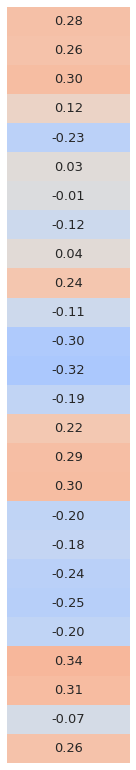

In [51]:
plt.figure(figsize=(2,10.8))


corr_mat =  df_partial_corrs[['partial corr']]

sns.heatmap(corr_mat,
           cmap = "coolwarm",  vmin=-1, vmax=1,  cbar=False, robust=True, annot = corr_mat, fmt = '.2f',
                annot_kws={'size':13})

plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)


In [53]:
features = [ 'Total Pop 100k', 'Log Pop Density',
            #'Pop Density 1k',
            #'frac_female', 
             'frac_asian',
            'frac_black',
       'frac_hispanic', 'frac_other', 
            'frac_18_to_39', 'frac_40_to_64', 'frac_over_65',
             'frac_20k_to_40k', 'frac_40k_to_75k', 'frac_75k_to_125k', 'frac_125k_to_200k', 'frac_gt_200k',
       'frac_unemployed', 'frac_no_health_insurance', 
        'frac_hs',  'frac_some_college', 'frac_college',
       'frac_graduate', 'frac_houses_owner_occupied', 'Median House Price 100k']


#features = []

X = sm.add_constant(df[features] ).fillna(0)

X = pd.concat([X, pd.get_dummies(df['State Name']).iloc[:,:-1].astype(int)], axis=1)
y = df[coverage_feature].clip(upper=clip_height)

est = sm.WLS(y, X, weights = df['weight']).fit() #maxiter=50000, method='nm') # weights = df_plot['Total Pop']
est.summary2()



<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Weighted least squares
==========================================================================
Model:                 WLS                Adj. R-squared:       0.589     
Dependent Variable:    coverage_medi      AIC:                  -5046.7507
Date:                  2023-04-16 09:55   BIC:                  -4738.7929
No. Observations:      502                Log-Likelihood:       2596.4    
Df Model:              72                 F-statistic:          10.96     
Df Residuals:          429                Prob (F-statistic):   1.05e-61  
R-squared:             0.648              Scale:                466.06    
--------------------------------------------------------------------------
                            Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                      -0.0064   0.0066 -0.9651 0.3351 -0.0194  0.0066
Total Pop 100k              0.0000   0.0000  4.2895 0.0000  0.0000  0.0000
Log Pop Density             0.0090   0.0210  0.4267 0.6698 -0.0323  0.0502
frac_asian                  0.0012   0.0029  0.4086 0.6831 -0.0045  0.0069
frac_black                 -0.0008   0.0011 -0.7158 0.4745 -0.0030  0.0014
frac_hispanic              -0.0053   0.0010 -5.3648 0.0000 -0.0072 -0.0033
frac_other                 -0.0065   0.0030 -2.1498 0.0321 -0.0124 -0.0006
frac_18_to_39              -0.0017   0.0058 -0.2934 0.7693 -0.0130  0.0096
frac_40_to_64               0.0100   0.0064  1.5716 0.1168 -0.0025  0.0225
frac_over_65               -0.0097   0.0052 -1.8735 0.0617 -0.0200  0.0005
frac_20k_to_40k            -0.0095   0.0109 -0.8784 0.3802 -0.0309  0.0118
frac_40k_to_75k             0.0136   0.0065  2.0949 0.0368  0.0008  0.0263
frac_75k_to_125k            0.0082   0.0081  1.0080 0.3140 -0.0078  0.0241
frac_125k_to_200k          -0.0140   0.0093 -1.4981 0.1348 -0.0323  0.0044
frac_gt_200k                0.0040   0.0077  0.5214 0.6024 -0.0111  0.0192
frac_unemployed             0.0192   0.0080  2.4010 0.0168  0.0035  0.0350
frac_no_health_insurance    0.0090   0.0034  2.6027 0.0096  0.0022  0.0157
frac_hs                    -0.0002   0.0052 -0.0375 0.9701 -0.0105  0.0101
frac_some_college          -0.0031   0.0037 -0.8499 0.3958 -0.0104  0.0041
frac_college                0.0013   0.0051  0.2437 0.8076 -0.0089  0.0114
frac_graduate               0.0106   0.0058  1.8402 0.0664 -0.0007  0.0220
frac_houses_owner_occupied  0.0031   0.0022  1.4299 0.1535 -0.0012  0.0074
Median House Price 100k     0.0000   0.0000  0.2617 0.7937 -0.0000  0.0000
Alabama                     0.0005   0.0012  0.3898 0.6969 -0.0019  0.0028
Alaska                     -0.0002   0.0014 -0.1664 0.8679 -0.0029  0.0025
Arizona                     0.0035   0.0012  3.0508 0.0024  0.0013  0.0058
Arkansas                    0.0004   0.0012  0.2996 0.7646 -0.0020  0.0027
California                  0.0022   0.0011  1.9256 0.0548 -0.0000  0.0045
Colorado                    0.0029   0.0011  2.5495 0.0111  0.0007  0.0051
Connecticut                 0.0013   0.0013  0.9964 0.3196 -0.0012  0.0038
Delaware                    0.0034   0.0015  2.2457 0.0252  0.0004  0.0065
District of Columbia       -0.0006   0.0018 -0.3179 0.7507 -0.0040  0.0029
Florida                     0.0025   0.0012  2.1619 0.0312  0.0002  0.0048
Georgia                     0.0004   0.0011  0.3399 0.7341 -0.0019  0.0026
Hawaii                      0.0027   0.0017  1.5666 0.1179 -0.0007  0.0061
Idaho                       0.0002   0.0012  0.1792 0.8578 -0.0022  0.0026
Illinois                    0.0016   0.0011  1.4091 0.1595 -0.0006  0.0038
Indiana                     0.0008   0.0012  0.6834 0.4947 -0.0015  0.0031
Iowa                        0.0003   0.0012  0.2689 0.7882 -0.0020  0.0027
Kansas                      0.0002   0.0012  0.1981 0.8430 -0.0021  0.0025
Kentucky                    0.0007   0.0012  0.5829 0.5603 -0.0017  0.003

In [54]:
results_as_html = est.summary().tables[1].as_html()
temp = pd.read_html(results_as_html, header=0, index_col=0)[0]
temp[1:23]

,coef,std err,t,P>|t|,[0.025,0.975]
Total Pop 100k,1.568000e-07,3.650000e-08,4.290,0.000,8.490000e-08,2.290000e-07
Log Pop Density,9.000000e-03,2.100000e-02,0.427,0.670,-3.200000e-02,5.000000e-02
frac_asian,1.200000e-03,3.000000e-03,0.409,0.683,-4.000000e-03,7.000000e-03
frac_black,-8.000000e-04,1.000000e-03,-0.716,0.475,-3.000000e-03,1.000000e-03
frac_hispanic,-5.300000e-03,1.000000e-03,-5.365,0.000,-7.000000e-03,-3.000000e-03
frac_other,-6.500000e-03,3.000000e-03,-2.150,0.032,-1.200000e-02,-1.000000e-03
frac_18_to_39,-1.700000e-03,6.000000e-03,-0.293,0.769,-1.300000e-02,1.000000e-02
frac_40_to_64,1.000000e-02,6.000000e-03,1.572,0.117,-3.000000e-03,2.200000e-02
frac_over_65,-9.700000e-03,5.000000e-03,-1.874,0.062,-2.000000e-02,0.000000e+00
frac_20k_to_40k,-9.500000e-03,1.100000e-02,-0.878,0.380,-3.100000e-02,1.200000e-02


In [43]:
#now make a map

In [ ]:
#roll down to county level

In [170]:
df_rolldown = pd.read_csv('crosswalk_after_2014.csv')
df_rolldown = pd.merge(df, df_rolldown, on=['MSA', 'EGEOLOC'])

In [171]:
df_rolldown

,Unnamed: 0_x,MSA,EGEOLOC,Total Pop,Square Miles,frac_female,frac_white,frac_black,frac_hispanic,frac_asian,...,Median House Price 100k,phat,weight,Unnamed: 0_y,State Name_y,FIPS State Code,FIPS County Code,County Name,Metropolitan/Micropolitan Statistical Area,Central/Outlying County
0,0,0,41,1146384,28989.177,0.510875,0.686095,0.239066,0.045957,0.005608,...,102.312874,0.001932,1,1168,Alabama,1,5,Barbour,Rural,Rural
1,0,0,41,1146384,28989.177,0.510875,0.686095,0.239066,0.045957,0.005608,...,102.312874,0.001932,1,1169,Alabama,1,11,Bullock,Rural,Rural
2,0,0,41,1146384,28989.177,0.510875,0.686095,0.239066,0.045957,0.005608,...,102.312874,0.001932,1,1170,Alabama,1,13,Butler,Rural,Rural
3,0,0,41,1146384,28989.177,0.510875,0.686095,0.239066,0.045957,0.005608,...,102.312874,0.001932,1,1171,Alabama,1,17,Chambers,Rural,Rural
4,0,0,41,1146384,28989.177,0.510875,0.686095,0.239066,0.045957,0.005608,...,102.312874,0.001932,1,1172,Alabama,1,19,Cherokee,Rural,Rural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,500,0,59,403534,89067.339,0.487768,0.848645,0.004644,0.089472,0.007593,...,246.902362,0.001525,1,3140,Wyoming,56,41,Uinta,Rural,Rural
3136,500,0,59,403534,89067.339,0.487768,0.848645,0.004644,0.089472,0.007593,...,246.902362,0.001525,1,3141,Wyoming,56,43,Washakie,Rural,Rural
3137,500,0,59,403534,89067.339,0.487768,0.848645,0.004644,0.089472,0.007593,...,246.902362,0.001525,1,3142,Wyoming,56,45,Weston,Rural,Rural
3138,501,16220,59,80610,5340.512,0.493661,0.868825,0.012505,0.083402,0.006364,...,202.600000,0.000691,1,1099,Wyoming,56,25,Natrona County,Metropolitan Statistical Area,Central


In [150]:
import geopandas as gpd
from mpl_toolkits.axes_grid1 import ImageGrid
import us
from shapely.geometry import Point, Polygon

In [152]:
contiguous_states = ['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'ID', 'IL', 'IN', 'IA', 'KS',
                     'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 
                     'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA',
                     'WA', 'WV', 'WI', 'WY']
others = ['AK', 'HI']

state_shapes = pd.DataFrame([])
county_shapes = pd.DataFrame([])

for state in us.states.STATES:
    if state.abbr in contiguous_states:
        state_shapes = pd.concat([state_shapes, gpd.read_file(state.shapefile_urls('state'))], axis=0)
        county_shapes = pd.concat([tract_shapes, gpd.read_file(state.shapefile_urls('county'))], axis=0)

In [172]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [189]:
county_shapes['FIPS State Code'] = county_shapes.STATEFP10.astype(int)
county_shapes['FIPS County Code'] = county_shapes.COUNTYFP10.astype(int)

df_temp = pd.merge(county_shapes[['FIPS State Code', 'FIPS County Code', 'geometry']],df_rolldown, on=['FIPS State Code', 'FIPS County Code'])

In [190]:
df_temp = df_temp.to_crs(epsg=3857)
state_shapes = state_shapes.to_crs(epsg=3857)

In [191]:
df_temp['representation_comm'] = 100 * df_temp.coverage_comm
df_temp['representation_medi'] = 100 * df_temp.coverage_medi
#df_temp

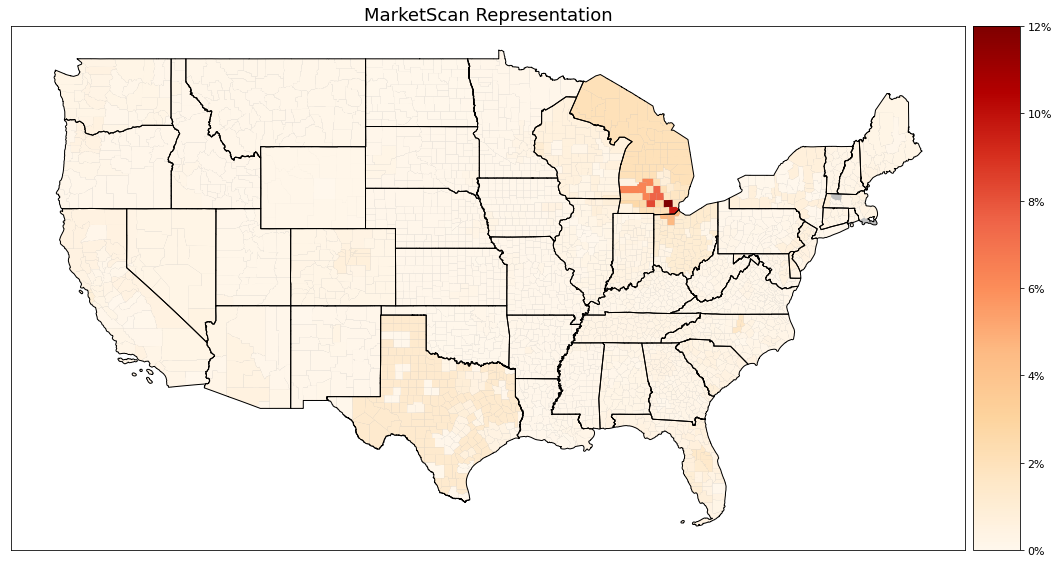

In [192]:
fig, ax = plt.subplots(1,1,figsize=(15,17 * 3.5/7.5))

state_shapes.plot(color = 'gray', alpha=0.5, ax=ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

df_temp.plot(column='representation_medi',
             cmap='OrRd',
             legend=True,
                vmin = 0,
                vmax = 12,
                ax=ax,
                cax=cax)


state_shapes.boundary.plot(color='k', ax=ax, linewidth= 1)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
    
ax.set_title('MarketScan Representation', fontsize=18)
    
cax.tick_params(labelsize=11)
cax.set_yticks([0, 2, 4, 6, 8, 10, 12])
cax.set_yticklabels(['0%', '2%', '4%', '6%', '8%', '10%', '12%'])


plt.tight_layout()
plt.savefig('map_MS.jpg', dpi=200)


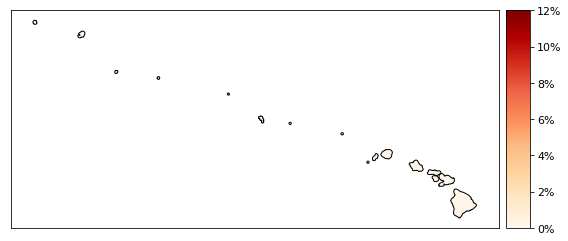

In [193]:
state = us.states.HI

state_shapes_o = gpd.read_file(state.shapefile_urls('state'))
county_shapes_o = gpd.read_file(state.shapefile_urls('county')) 

county_shapes_o['FIPS State Code'] = county_shapes_o.STATEFP10.astype(int)
county_shapes_o['FIPS County Code'] = county_shapes_o.COUNTYFP10.astype(int)
df_temp = pd.merge(county_shapes_o[['FIPS State Code', 'FIPS County Code', 'geometry']],df_rolldown, on=['FIPS State Code', 'FIPS County Code'])

df_temp = df_temp.to_crs(epsg=3857)
state_shapes_o = state_shapes_o.to_crs(epsg=3857)

df_temp['representation_comm'] = 100 * df_temp.coverage_comm
df_temp['representation_medi'] = 100 * df_temp.coverage_medi



fig, ax = plt.subplots(1,1,figsize=(8,8))

state_shapes_o.plot(color = 'gray', alpha=0.5, ax=ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

df_temp.plot(column='representation_medi',
             cmap='OrRd',
                legend=True,
                vmin = 0,
                vmax = 12,
                ax=ax,
                cax=cax)

#county_shape.boundary.plot(color='k', ax=ax, linewidth= 0.5)
state_shapes_o.boundary.plot(color='k', ax=ax, linewidth= 1)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

cax.set_yticks([0, 2, 4, 6, 8, 10, 12])
cax.set_yticklabels(['0%', '2%', '4%', '6%', '8%', '10%', '12%'])
    
ax.set_title('', fontsize=18)
    
cax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('map_HI_MS.jpg', dpi=200)



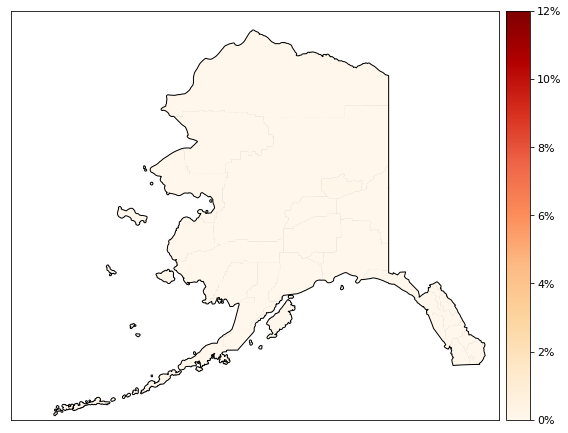

In [194]:
state = us.states.AK

state_shapes_o = gpd.read_file(state.shapefile_urls('state'))
county_shapes_o = gpd.read_file(state.shapefile_urls('county')) 

county_shapes_o['FIPS State Code'] = county_shapes_o.STATEFP10.astype(int)
county_shapes_o['FIPS County Code'] = county_shapes_o.COUNTYFP10.astype(int)
df_temp = pd.merge(county_shapes_o[['FIPS State Code', 'FIPS County Code', 'geometry']],df_rolldown, on=['FIPS State Code', 'FIPS County Code'])

df_temp = df_temp.to_crs(epsg=3857)
state_shapes_o = state_shapes_o.to_crs(epsg=3857)

df_temp['representation_comm'] = 100 * df_temp.coverage_comm
df_temp['representation_medi'] = 100 * df_temp.coverage_medi




fig, ax = plt.subplots(1,1,figsize=(8,8))

state_shapes_o.plot(color = 'gray', alpha=0.5, ax=ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

df_temp.plot(column='representation_medi',
             cmap='OrRd',
                legend=True,
                vmin = 0,
                vmax = 12,
                ax=ax,
                cax=cax)

#county_shape.boundary.plot(color='k', ax=ax, linewidth= 0.5)
state_shapes_o.boundary.plot(color='k', ax=ax, linewidth= 1)


ax.set_xlim([-2.05e7, -1.43e7])
ax.set_ylim([6.6e6, 11.8e6])

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

cax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

cax.set_yticks([0, 2, 4, 6, 8, 10, 12])
cax.set_yticklabels(['0%', '2%', '4%', '6%', '8%', '10%', '12%'])
    
ax.set_title('', fontsize=18)
    
cax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig('map_AK_MS.jpg', dpi=200)

In [ ]:
#figuring out the 1 situations

In [278]:
df_ms[df_ms.EGEOLOC==1].mem_days_medi.sum()/df_ms.mem_days_medi.sum() * 100

46.17259455894648

In [280]:
df_ms[(df_ms.EGEOLOC!=1) & (df_ms.MSA.isna())].mem_days_medi.sum() /df_ms.mem_days_medi.sum() * 100

16.72246409736535

In [282]:
df_ms[df_ms.EGEOLOC==1].groupby('MSA').mem_days_medi.sum()

MSA
0.0        19364446.0
10380.0         396.0
11244.0        8064.0
11460.0     1615782.0
11500.0         365.0
              ...    
48864.0           0.0
48900.0        6175.0
49180.0        6813.0
49340.0        5536.0
49420.0        2190.0
Name: mem_days_medi, Length: 149, dtype: float64

In [283]:
19364446.0/df_ms.mem_days_medi.sum() * 100

9.154530373882332

In [ ]:
Making Supp Fig 6

In [11]:
df_temp = pd.read_exce] = np.log(df_temp.rel_bias)

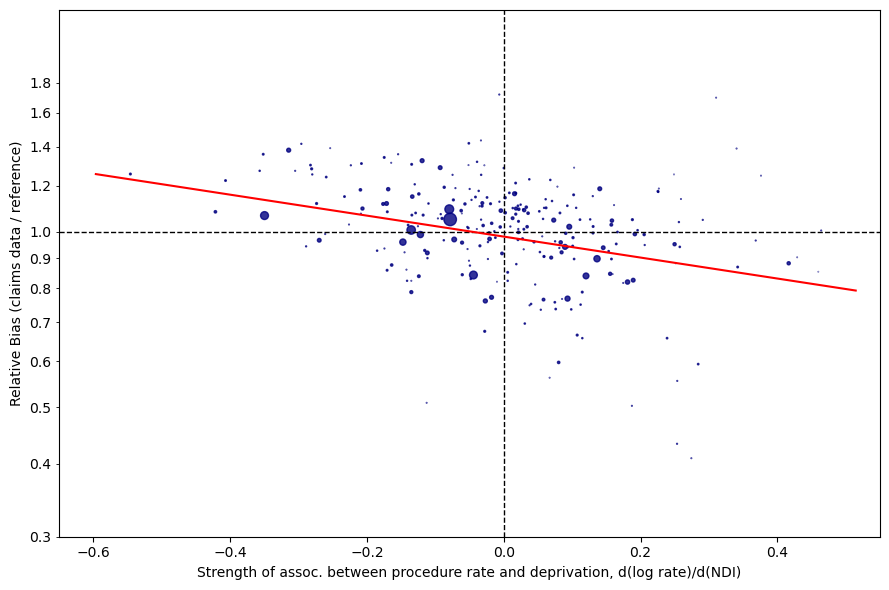

In [13]:
fig, ax = plt.subplots(1,1,figsize=(9,6))

sns.regplot(y='rel_bias', x = 'slope_ses', data=df_temp,
            scatter_kws={'s': df_temp['rate_SID']*100,  'color':'navy'}, fit_reg = False)

#ax.errorbar(x=df_temp['slope_ses'], y=df_temp['log_rel_bias'], 
#            xerr=1.96*df_temp['slope_ses_se'], 
#            yerr=df_temp['log_rel_bias'] - np.log(df_temp['rel_bias_low']), 
#            fmt='none', capsize=2, color='k')

#sns.regplot(y='log_rel_bias', x = 'slope_ses', data=df_temp,
#            scatter_kws={'s': 3,  'color':'red', 'zorder':4}, fit_reg = False)

plt.axhline(1,linestyle='--', color='k', lw=1,)
plt.axvline(0,linestyle='--', color='k', lw=1,)

ax.set_yscale('log')

est = sm.WLS(exog = sm.add_constant(df_temp['slope_ses']),
             endog = df_temp.log_rel_bias,
             #weights=df_temp['rate_SID']
             weights=df_temp['slope_ses_se']**-2).fit()
intercept = est.params['const']
slope = est.params['slope_ses']
x_vals = np.array(plt.xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, np.exp(y_vals), 'r-')

plt.xlim([-0.65, 0.55])
#plt.xlim([-0.21, 0.21])
plt.ylim([0.3, 2.4])

locs = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 1.2, 1.4, 1.6, 1.8])
labels = np.array(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', '1.2', '1.4', '1.6', '1.8'])

ax.yaxis.set_minor_locator(ticker.FixedLocator(locs))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter(labels))
ax.yaxis.set_major_locator(ticker.NullLocator())

#plt.title('Procedures with more bias occur disproportionately in lower SES zip codes', size=14)

plt.xlabel('Strength of assoc. between procedure rate and deprivation, d(log rate)/d(NDI)')

plt.ylabel('Relative Bias (claims data / reference)')
plt.tight_layout()
plt.savefig('temp.jpg', dpi=400)
plt.show()

In [14]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:           log_rel_bias   R-squared:                       0.174
Model:                            WLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     52.30
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           5.90e-12
Time:                        15:51:10   Log-Likelihood:                 34.213
No. Observations:                 250   AIC:                            -64.43
Df Residuals:                     248   BIC:                            -57.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0192      0.009     -2.209      0.028      -0.036      -0.002
slope_ses     -0.4138      0.057     -7.232      0.000      -0.527      -0.301
==============================================================================
Omnibus:                       40.473   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.205
Skew:                          -0.810   Prob(JB):                     8.56e-19
Kurtosis:                       5.316   Cond. No.                         6.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""